# INFO 2950 Final Project: The Analysis of the Housing Market

Sander Rodman (ahr68), Abigale Watson (aaw83), Grace Wei (gtw25)

# __Introduction:__ 
In this project, we aim to analyze the condition of the housing market in the United States from the years 2018-2023, and what socioeconomic factors(birth and mortality rates, inflation, and unemployment) impact the market. We want to quantify the condition of the housing market by the number of new listings and the sale-to-list price ratio, which is the ratio of the original list price and the final sale price of the house. 

To predict the number of new listings we are examining birth count, death count, inflation rate, and unemployment rate. The rationale for considering birth count is that as a family grows, there is typically an increased need for more space to accommodate their larger family. Death count is a crucial factor because when a person who owns a house passes away, their family members often sell their houses. We have also adjusted the deaths by three months, considering that families may wait before selling the house. We also included inflation rate and unemployment rate because these are indicators of the health of the economy. When the economy is bad people typically sell their homes due to a need to downsize. When examining the sale to price ratio we include days to pending, inflation rate, and unemployment rate. Days-to-pending is defined as the number of days until the seller accepts the first offer. Days to pending is an important factor because typically the longer a house stays on the market the more willing their sellers are to be flexible with their pricing. We are also including inflation rate because as inflation rate increases the sale price of the house also increases. Due to inflation the listed price of the houses does not affect the true value of the house, and buyers would need to make a higher offer to account for this discrepancy. Lastly we included the unemployment rate because as unemployment increases housing sale price decreases. We expected that sellers would be more willing to be flexible with the offer that they expect because they are more eager to sell their houses. https://docs.iza.org/dp10941.pdf

In our research, we built several models. First, we specifically looked at the relationship between the birth count and the number of houses that were newly listed. We found a positive linear correlation between the two. Then we examined the relationship between the number of days a house spends on the market before it becomes “Pending” and the sale-to-list-price ratio. There, we found a negative log-linear relationship between those variables. 

Then, we ran multiple linear regressions on our two target variables–the number of new listings, and the sale-to-list-price ratios. We found the effects that several variables had on each.

The goal of this project is to gain a better understanding of the impacts of society on the housing market in general. Can we predict what the market will look like based on events going on at the time? The results of this project aim to provide information to both people looking to sell their houses, and people looking to buy.

### Key Terminology / Definitions

Linear regression - a model used to predict an unknown value of a variable based on the known value of another variable. 

Multivariate regression - a method of modeling multiple responses, or dependent variables, with a single set of predictor variables.

Sliding window validation - since our dataset is a time series, the sliding window validation ensures that the machine learning model built in the training process is evaluated on data after the training window. This prevents any data leakage caused by predicting on future data.

Root Mean Square Error (RMSE) - measures the average difference between values predicted by a model and the actual values. It provides an estimation of how well the model is able to predict the target value (accuracy).

Mean absolute error (MAE) - a measure of errors between paired observations expressing the same phenomenon.

Sale-To-List-Price Ratio - The ratio of the price that a house is sold at over the price at which it is initially listed. This is a measure of how the price changes.

Adjusted deaths - events usually don't have an immediate impact on the economy. We adjusted our `Deaths` data by three months to reflect time between one's passing and their home being listed for sale (https://www.homelight.com/blog/how-long-does-executor-have-to-sell-a-house/)

In [369]:
# importing packages
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import duckdb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, \
mean_absolute_percentage_error, accuracy_score, precision_score, \
recall_score, f1_score, precision_recall_curve
from sklearn.model_selection import KFold, cross_val_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.ticker

# __Dataset:__

We collected data from several different sources. For each of the factors that we will examine, we acquired a dataset of monthly data in the U.S. regarding that factor.

We then had to reshape our data and merge it into one large dataframe, which is in the file `housing_data_df.csv`.

The full collection and cleaning procedure can be found in the data cleaning appendix, found in the file `DataCleaningAppendix.ipynb` in the Github repository.

In [370]:
housing_data_df = pd.read_csv("housing_data_df.csv")
housing_data_df

,Year,Month,New_Listings,Days_To_Pending,Percent_Sold_Below_List,Sale_To_List_Price_Ratio,Births,Deaths,Inflation_Rate,Unemployment_Rate,Months_Since_Jan_2018
0,2018,jan,NaN,47.0,0.642516,0.976664,314808.0,NaN,2.1,4.0,0
1,2018,feb,NaN,25.0,0.619052,0.978713,284250.0,NaN,2.2,4.1,1
2,2018,mar,1421529.0,20.0,0.577498,0.983239,316044.0,NaN,2.4,4.0,2
3,2018,apr,1500194.0,18.0,0.551780,0.986186,298394.0,286744.0,2.5,4.0,3
4,2018,may,1592414.0,18.0,0.533494,0.987151,320622.0,236998.0,2.8,3.8,4
...,...,...,...,...,...,...,...,...,...,...,...
64,2023,may,880510.0,10.0,0.419565,0.997535,NaN,249084.0,4.0,3.7,64
65,2023,jun,907228.0,11.0,0.399708,1.000553,NaN,269173.0,3.0,3.6,65
66,2023,jul,930911.0,12.0,0.411186,0.998900,NaN,251959.0,3.2,3.5,66
67,2023,aug,950306.0,13.0,0.434983,0.995926,NaN,252046.0,3.7,3.8,67


# __Data Description:__
**What are the observations (rows) and the attributes (columns)?**

Our data is essentially a time series, so each row represents a different month from 
January 2018 – August 2023. The columns represent the different factors that we wish to explore in our analysis. We have one column each for the year and month–these are meant to be the identifiers for each row. Then, we have one column for each of the eight different factors:

- `Num_Listings` represents the number of new listings that were posted in the given month.
- `Days_To_Pending` represents the median amount of time that houses took to go from “listed” to “pending” status (which refers to when the sellers first accept an offer), in days.
- `Percent_Sold_Below_List` represents the percentage of houses that were sold for a price that was below their final listing price.
- `Sale_To_List_Price_Ratio` represents the mean ratio of homes’ sale prices over their final listing prices.
- `Births` represents the number of births   
- `Deaths` represents the number of deaths	
- `Inflation_rate` represents the rate at which prices for goods and services rise
- `unemployment_rate` represents the number of unemployed people as a percentage of the labor force. 

**Why was this dataset created?**

The housing data was all created by the Zillow research team in order to analyze the housing market and make predictions for the future housing market.
	The data from birth_df and mortality_df is from the CDC Wonder, which was developed from the Center for Disease Control and Prevention. Their goal is to make the information collected from the CDC available to the public. 
The data from unemployment_df and inflation_df is from the Bureau of Labor Statistics, which measures the productivity in the U.S economy to support public and private decision making.

**Who funded the creation of the dataset?**

The data that we gathered on birth and mortality rates came from the CDC, so it is from the census and funded by the government and tax revenue. The unemployment rate data came from the Bureau of Labor Statistics, so also a government organization, and the inflation rate data was calculated using data from the Bureau of Labor Statistics as well. The housing data was funded by Zillow’s research department.


**What processes might have influenced what data was observed and recorded and what was not?**

Since our housing data is exclusively from Zillow, an online real estate website, our data does not include any transactions that took place offline. These types of transactions usually take place in more rural areas and are difficult to access. 


**What preprocessing was done, and how did the data come to be in the form that you are using?**

We gathered the data from nine different data tables. Each individual table required downloading and conversion to a pandas dataframe, and some of them required conversion from a .xslx file to a .csv file. After we loaded in all of our data, we needed to reshape and rename the tables in order to be able to merge them (more details in the cleaning section).

**If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?**

A lot of our data can be traced back to the U.S. census, which would involve all American citizens. Participation in the census is required by law (per https://www.census.gov/programs-surveys/censuses.html), and the data is used for government functions as well as keeping track of the general U.S. population.

**Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted on Github, in a Cornell Google Drive or Cornell Box)**
Our raw data can be found in the following links:
- Data on sale of houses (all Zillow data): https://www.zillow.com/research/data/
- Data on unemployment rate: https://data.bls.gov/timeseries/LNS14000000
- Data on inflation: https://www.usinflationcalculator.com/inflation/current-inflation-rates/ 
- Data on births: https://wonder.cdc.gov/natality-expanded-current.html 
- Data on mortality: https://wonder.cdc.gov/ucd-icd10-expanded.html 

The downloaded .csv files can be found in the project repository.


**Are there any errors, sources of noise, or redundancies in the dataset?**

There were missing or empty cells (NaNs) in our dataset. We accounted for these errors by removing them. In the zillow data tables, there was a slight redundancy in that there was a row for the entire country followed by rows for the major cities. The city data comprises almost all country-wide data, as most of the platform’s users are in urban regions.

**Is the dataset self-contained, or does it link to or otherwise rely on external resources?**

All of the data involved in the larger dataset was directly downloaded into files. It is self-contained.

















# __Preregistration Statements$^{+}$:__

__Research sub-question 1__ <br>
Hypothesis 1: In the US, more homes go on the market as the birth count (per month) increases.

&emsp;$H_0: β_{births} <= 0$ <br>
&emsp;$H_A: β_{births} > 0$

Analysis: We will run a linear regression where we input the birth count per month, and output the number of new listings per month. We will test if βbirths > 0.

We will run this test with an alpha value of 0.05, and reject our null hypothesis if the calculated p-value is less than the 0.05.

__Research sub-question 2__ <br>
Hypothesis 2: In the US, as the number of days before a house becomes pending increases*, the ratio of the house’s sale price over the final listing price decreases.

Analysis: We will run a linear regression where we input the number of days a house remains on the market, and output the sale-to-list price ratio. We will test if βdays_to_pending < 0. 

&emsp;$H_0: β_{days\_to\_pending} >= 0$ <br>
&emsp;$H_A: β_{days\_to\_pending} < 0$

We will run this test with an alpha value of 0.05, and reject our null hypothesis if the calculated p-value is less than the 0.05.

*The wording of the hypothesis has changed since our initial submission. Before, it said ”as the number of days a house stays on the market increases,” however we were referring to the `Days_To_Pending` values so we clarified this to prevent any misunderstanding. <br>
$^{+}$We also inserted null and alternative hypotheses for each of the questions.


# __Data Analysis:__

First of all, before we begin analyzing our data, we need to address the fact that we are using two columns (`Month` and `Year`) as the unique identifiers for each of our rows. So, we create a list of the two columns concatenated to serve as labels for our graphs and improve readability. We also increased the size of the plot and it's font for better legibility.

In [371]:
housing_date = housing_data_df['Month'].astype(str) + " / " + \
    housing_data_df['Year'].astype(str)

sns.set(rc = {'figure.figsize':(20,8)})
sns.set(font_scale=1.5)

We’ll begin by examining our target variables. The two factors that we will be measuring in particular are the number of new listings per month, and the median sale-to-list-price ratio of houses sold in that month. 

Since our data is a time-series, it is worthwhile to take a look at how each of these factors change over time. Below is a graph that shows the number of new listings each month from March 2018 to September 2023 (the data did not . We chose to use a bar graph because we are plotting quantities.

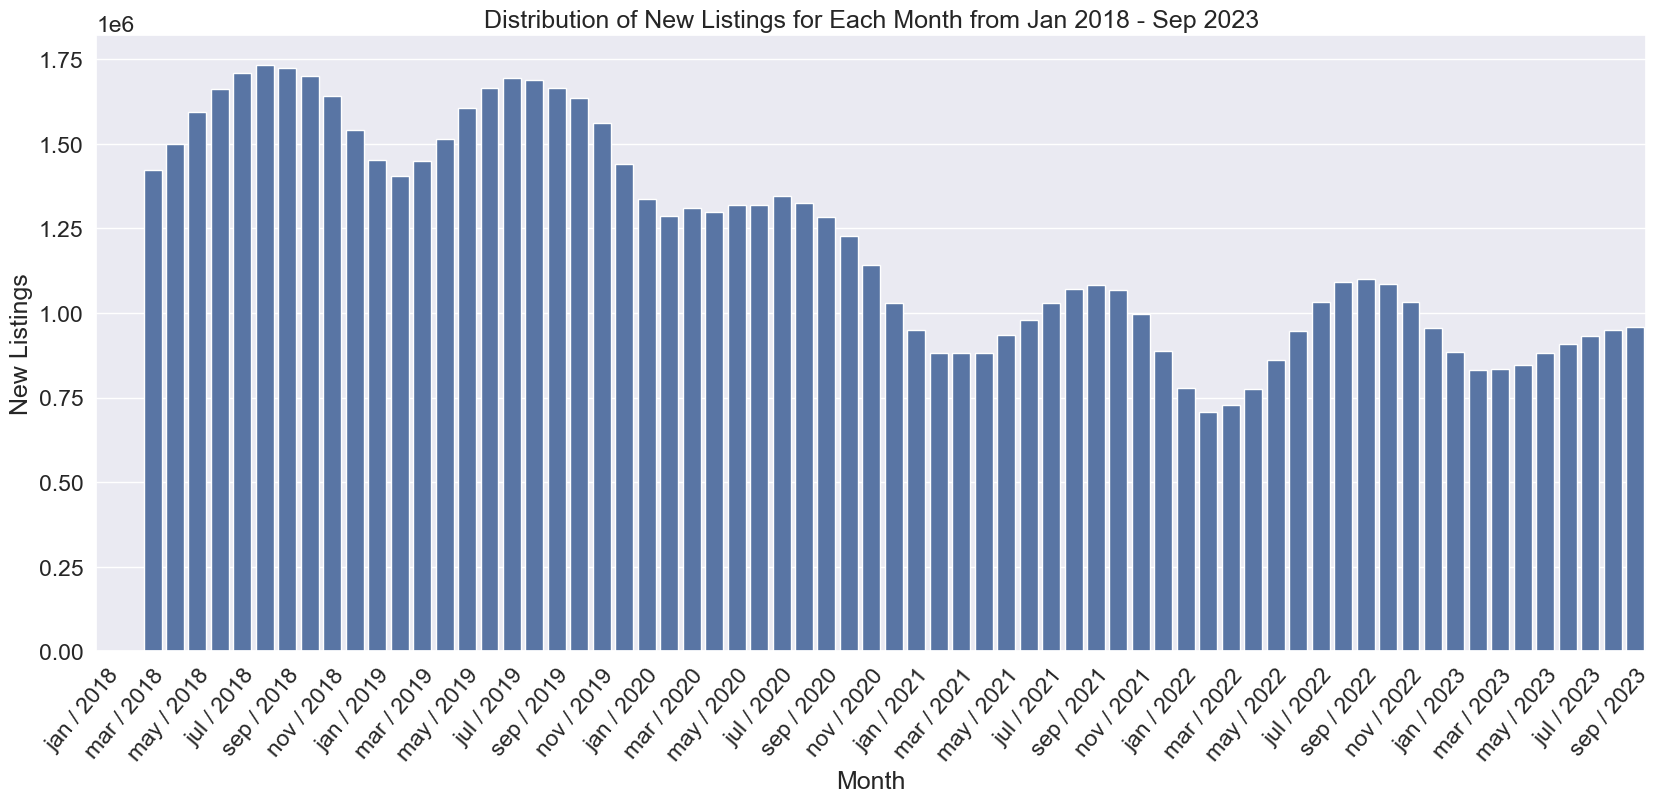

In [372]:
y_str = 'New_Listings'
bar = sns.barplot(data=housing_data_df, x=housing_date, \
                  y=y_str)
plt.xlabel("Month")
plt.xticks(rotation=50, ha='right', rotation_mode='anchor')
plt.ylabel(" ".join(y_str.split('_')))
plt.title(f"Distribution of {' '.join(y_str.split('_'))} for Each Month from Jan 2018 \
- Sep 2023")
plt.setp(bar.get_xticklabels()[1::2], visible=False);

As shown in the graph, there seems to be a general trend that occurs from year to year. The number of new listings tends to increase in the beginning of the year and decrease during the latter half of the year. From 2018 to 2023, there was an overall general decrease in the number of new listings. There are a few implications for these observations. We hypothesize that there are more listings in the middle of the year due to the summer vacation, which makes it easier for families to move. We are unsure if the observed decrease over the years is a persisting trend; it’s possible that it is related to other economic impacts from current events, such as COVID. We could test this if we had more data from previous years, or we revisit the experiment in the future.

Here is the graph for the sale-to-list-price distribution over the months from January 2018 to September 2018.

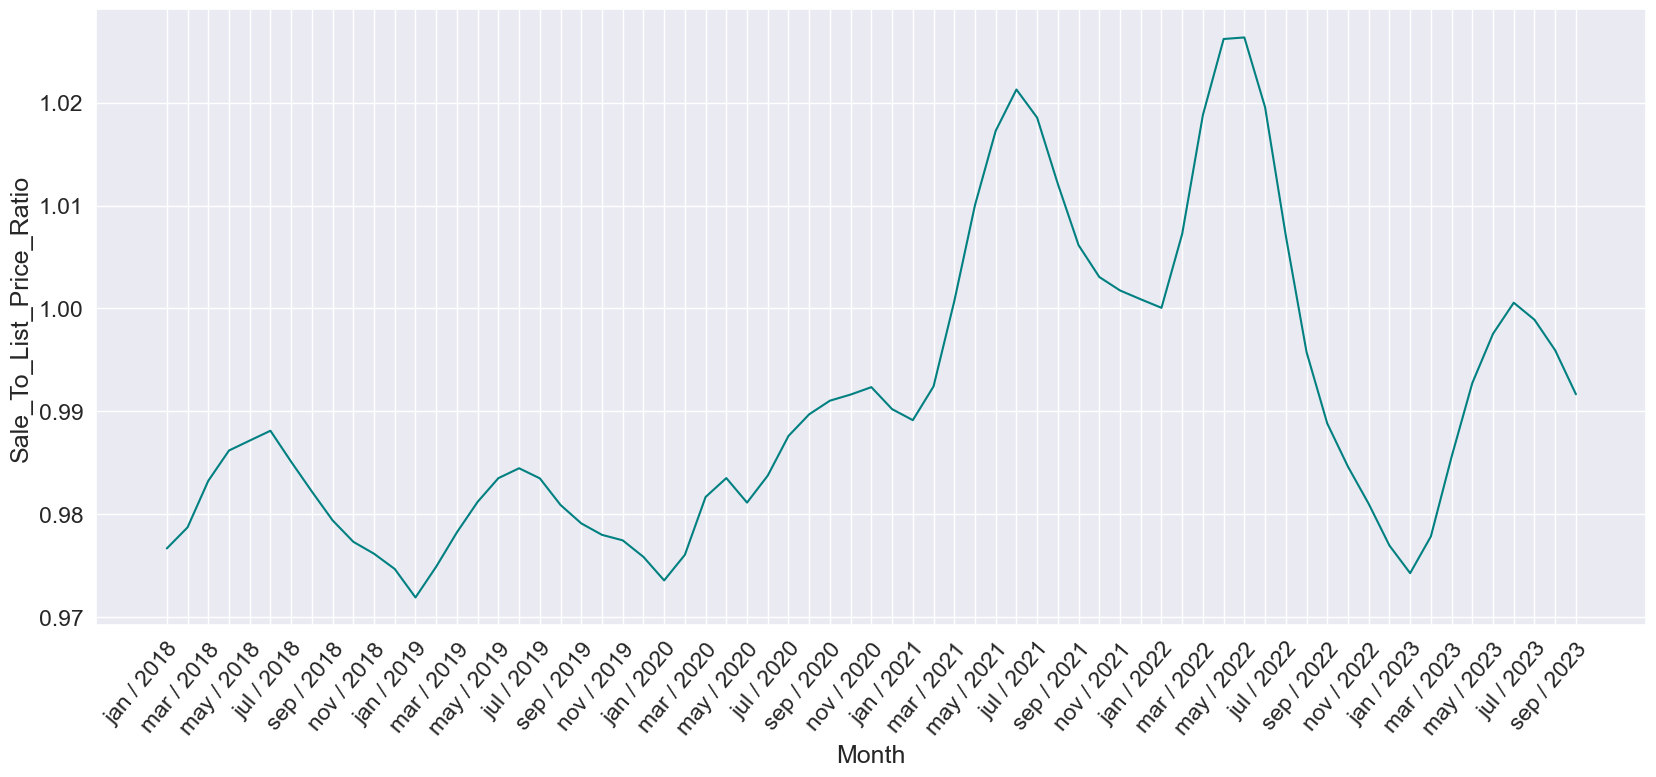

In [373]:
slp_graph = sns.lineplot(data=housing_data_df, x=housing_date, \
             y='Sale_To_List_Price_Ratio', color='teal')
plt.xlabel("Month")
plt.xticks(rotation=50, ha='right', rotation_mode='anchor')
plt.setp(slp_graph.get_xticklabels()[1::2], visible=False);

The sale-to-list-price ratio fluctuates from month to month. We see that there is a general shape that appears each year, but it isn’t very well-defined. Also, the sale-to-list-price ratio increased dramatically during the years 2021 and 2022. Again, we may be seeing impacts from events  such as COVID, so we would need more data to get a better understanding.

## Sliding Window

For our anlyses, we want to run linear regressions, so we need to confirm that the linear regression model we created is a valid model for our data. Since our dataset is small, we cannot just split it into a single train and test set. Given that our data was collected over time, we will use a sliding window validation model to check that the linear regression was appropriate. Before we get into the analyses, we will define and implement a few functions that will assist in our sliding window validation.

First, we write a function to get all of the windows that we will use. This was sourced from https://medium.com/geekculture/implement-a-sliding-window-using-python-31d1481842a7. 

In [374]:
def sliding_window(elm, w_size):
    window = []
    if len(elm) <= w_size:
        return [elements]
    for i in range(len(elm) - w_size + 1):
        window.append(elm[i:i+w_size])
    return window

Then, we create a function that takes in the list of windows that we created, and returns the predictions for each window on the next interval of time (i.e. the next month). This was also referenced from the same source.

In [375]:
def window_pred(windows, x, y):
    preds = []
    for i in range(len(windows)-1):
        model = LinearRegression().fit(windows[i][x].values, windows[i][[y]])
        p = windows[i+1][x].values[-1]
        preds.append(model.predict([p])[0][0])
        
    for n in range(len(windows[0])):
        preds.insert(0, np.NAN)
    
    return preds

These functions will be useful for validation purposes in all of our research questions.

### Research Sub-question 1:

For our first research question, we want to look at the relationship between birth count and the number of new listings. We wish to see whether or not the number of births in a given month affects the number of houses listed in that month. This is important because a significant correlation between the two can give homeowners an idea of whether or not it would be a good idea to sell their home if they know the birth count during that month. We predict that there will be a positive relationship between the number of births and the number of new listings because drastic family events, such as a new family member, can be reasons for a family to relocate/move houses. So, our hypotheses will be as follows:

&emsp;$H_0: β_{births} <= 0$ <br>
&emsp;$H_A: β_{births} > 0$

Using an alpha-value of 0.05, we will reject our null hypothesis (that birth count has a negative or no relationship with the number of new listings) if our calculated p-value is less than 0.05.


**Number of New Listings Per Number of Births**  
In order to calculate any values to measure this relationship, we need to first understand the general relationship between the two variables. We graphed a line graph to show this relationship. Note that the y-axis units are in millions, so changes in the graph are quite large.

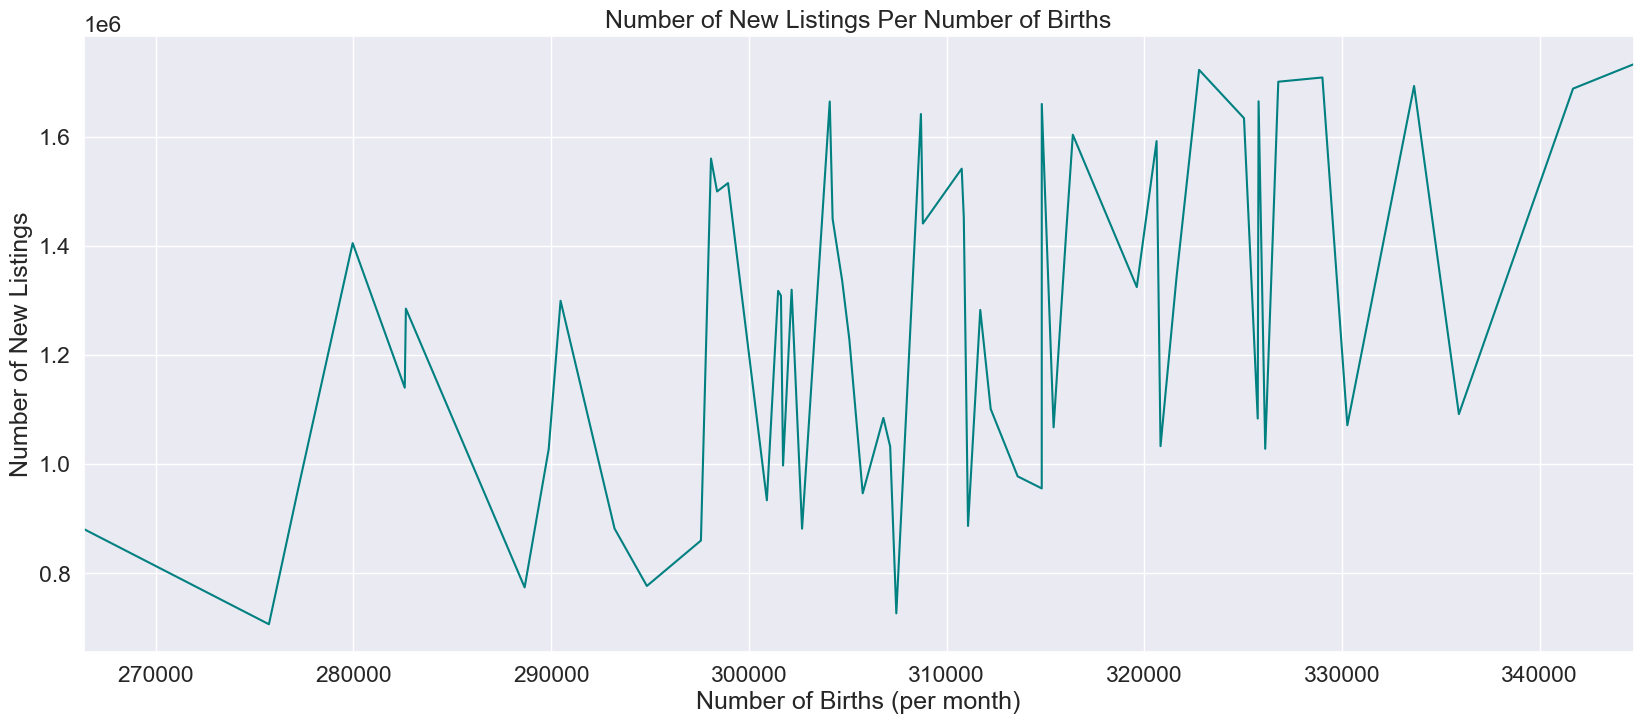

In [376]:
sns.lineplot(data=housing_data_df, x='Births', \
             y='New_Listings', color='teal')
plt.title("Number of New Listings Per Number of Births")
plt.xlabel("Number of Births (per month)")
plt.ylabel("Number of New Listings")
plt.margins(x=0);

There is a lot of variation in this graph. However, overall, there is a general trend that the number of new listings tends to increase as the number of births in the country increases. We will conduct further investigation to measure whether or not the birth count truly has a significant impact on the mean sale-to-list-price ratio.

#### Linear Regression

We plan on running a linear regression to see if we can find a quantifiable relationship. Before we create a model, we need to address the fact that the `Births` column is missing data at the end, so it is not the same length as the `New_Listings` column. We cannot run a regression on null values, so for the sake of this analysis, we will create a new dataframe with the NaN values dropped.

In [377]:
reg_df_1 = housing_data_df[["Births", "New_Listings"]]
reg_df_1 = reg_df_1.dropna().reset_index(drop=True)

Now, we will use sliding window validation to ensure that a linear regression is an appropriate model for our data. We will calculate predictions from consecutive segments of our data (a.k.a. "windows") and plot the residuals. If we find a clear pattern in our calculated residuals, that is an indication that our data needs to be transformed. 

So, we first use the functions we defined in the "Sliding Window" section to create create the windows and predictions for our data on the births and new listings.

In [378]:
windows = sliding_window(reg_df_1, 9)
preds = window_pred(windows, ["Births"], "New_Listings")

We then calculate the residuals from each of our predictions, and put into our larger dataframe. Since the first calculated window will not have predictions, we need to drop those.

In [379]:
reg_df_1["Predictions"] = preds
reg_df_p_1 = reg_df_1.dropna().reset_index(drop=True)
residuals = reg_df_p_1["New_Listings"] - reg_df_p_1["Predictions"]

Now we will plot the actual number of `New_Listings` against our predictions. This will give us an indication of how our model holds.

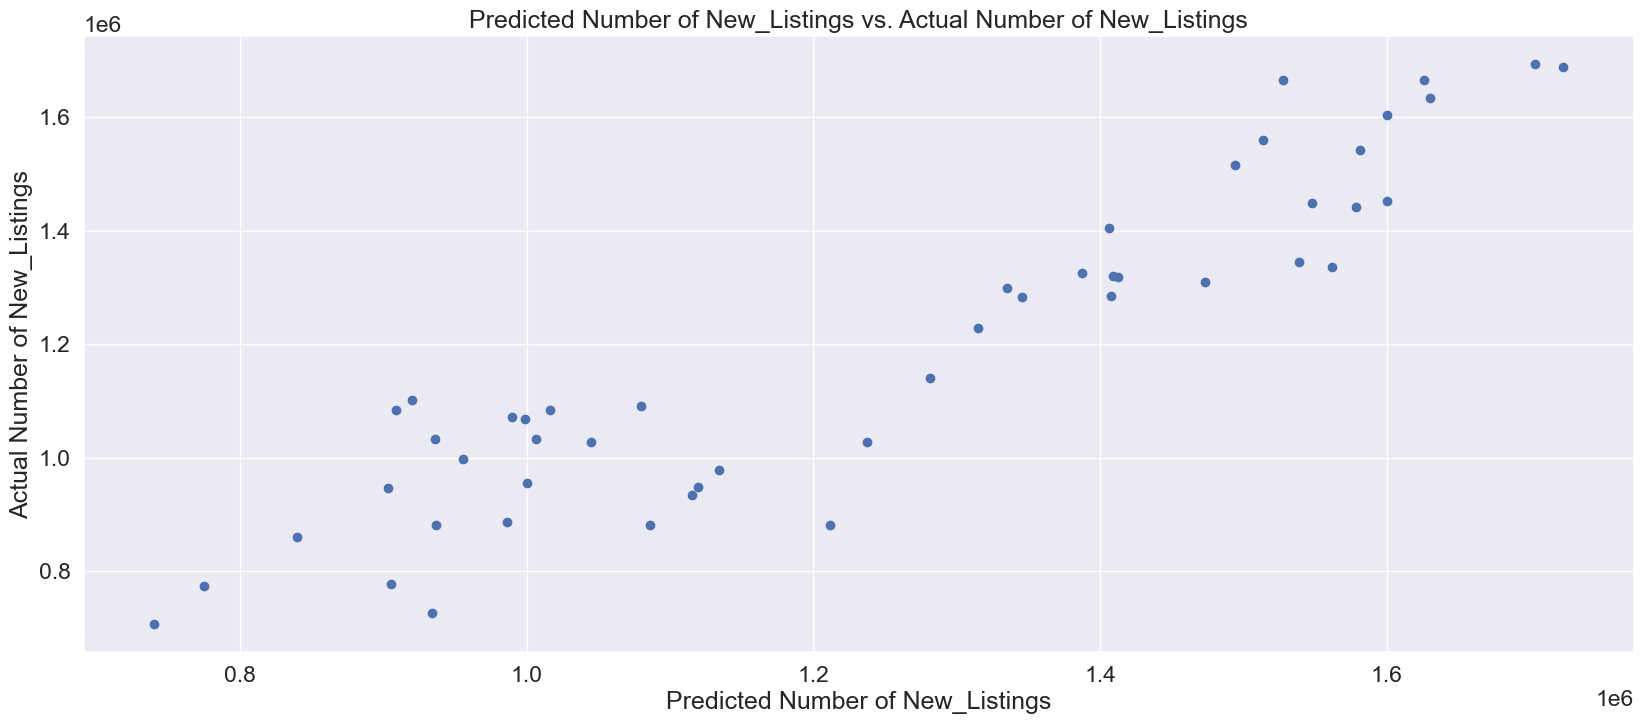

In [380]:
plt.scatter(x=reg_df_p_1["Predictions"], y=reg_df_p_1["New_Listings"])
plt.ylabel("Actual Number of New_Listings")
plt.xlabel("Predicted Number of New_Listings")
plt.title("Predicted Number of New_Listings vs. Actual Number of New_Listings");

We will also create the residual plot. We are looking for any distinct shapes or patterns.

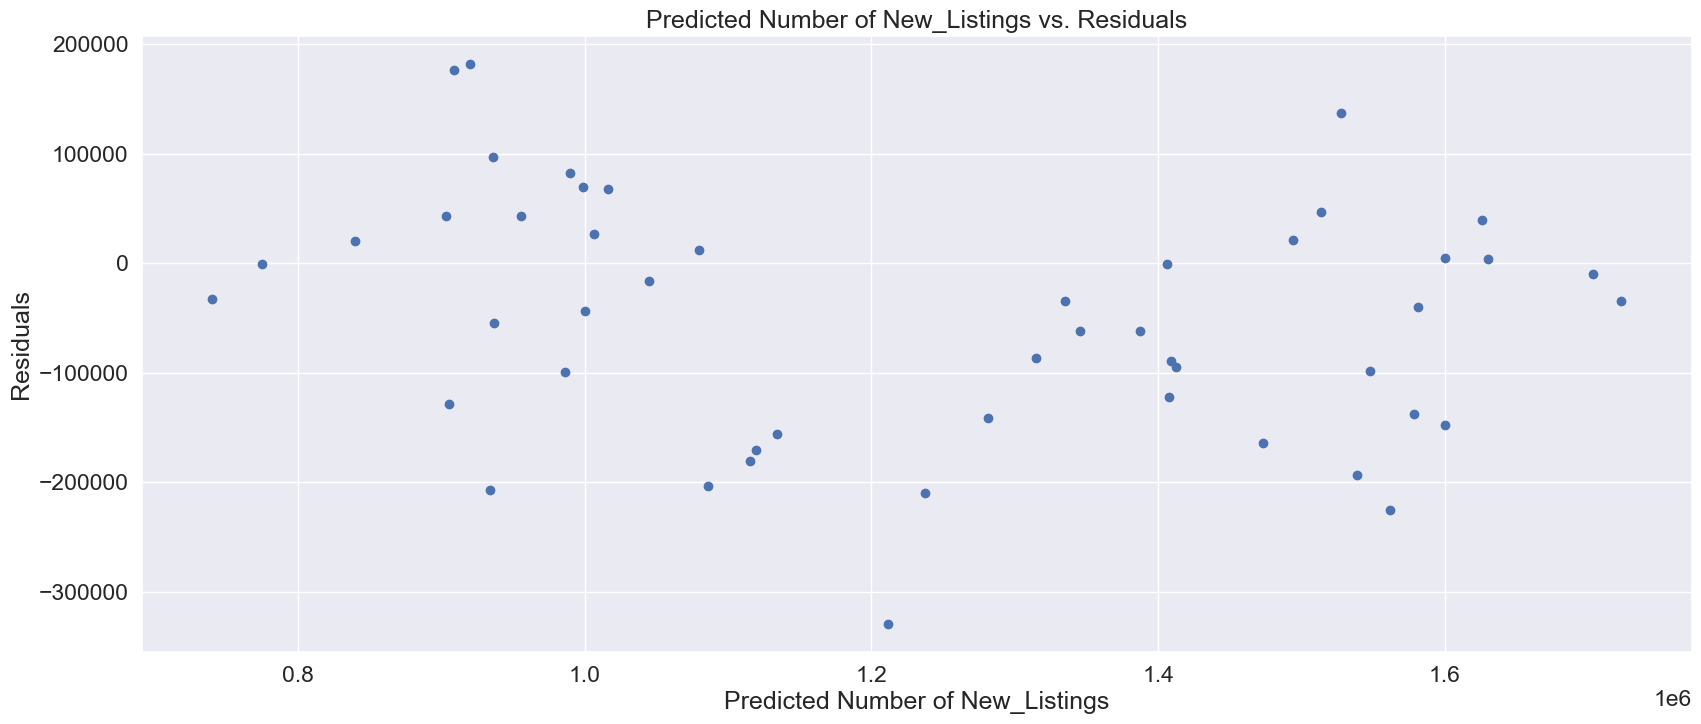

In [381]:
plt.scatter(x=reg_df_p_1["Predictions"], y=residuals)
plt.ylabel("Residuals")
plt.xlabel("Predicted Number of New_Listings")
plt.title("Predicted Number of New_Listings vs. Residuals");

The graph shows that the residual plot is randomly scattered, so a linear regression was an appropriate model. It should be noted that some of the residuals are quite large, so our model may not be the greatest. More considerations below.

So, we will calculate the root-mean-square error and the mean absolute error.

In [382]:
RMSE = mean_squared_error(reg_df_p_1["New_Listings"], 
                          reg_df_p_1["Predictions"], squared = False).round(2)
print(f"RMSE: {RMSE}")

MAE = mean_absolute_error(reg_df_p_1["New_Listings"], 
                          reg_df_p_1["Predictions"]).round(2)
print(f"MAE: {MAE}")

RMSE: 120389.05
MAE: 94915.55


Both of these errors are quite large.

Now, we will run a regression on our two variables. We will run an OLS linear regression (see “validation” section below), and focus on the value of the coefficient of `Births` in the equation.

In [383]:
x = sm.add_constant(reg_df_1["Births"])
y = reg_df_1["New_Listings"]

model = sm.OLS(y,x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           New_Listings   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     15.93
Date:                Mon, 04 Dec 2023   Prob (F-statistic):           0.000193
Time:                        21:57:23   Log-Likelihood:                -807.64
No. Observations:                  58   AIC:                             1619.
Df Residuals:                      56   BIC:                             1623.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.452e+06    6.8e+05     -2.136      0.0

Our model shows a coefficient of 8.7883. This means that for each additional birth per month, our model predicts about 8.7883 more homes being listed on the market. Since the p-value is 0.000, we can reject the null hypothesis. This confirms that there is a positive relationship between the number of births and the number of listings.

So, we will make a regplot so see how our model fits.

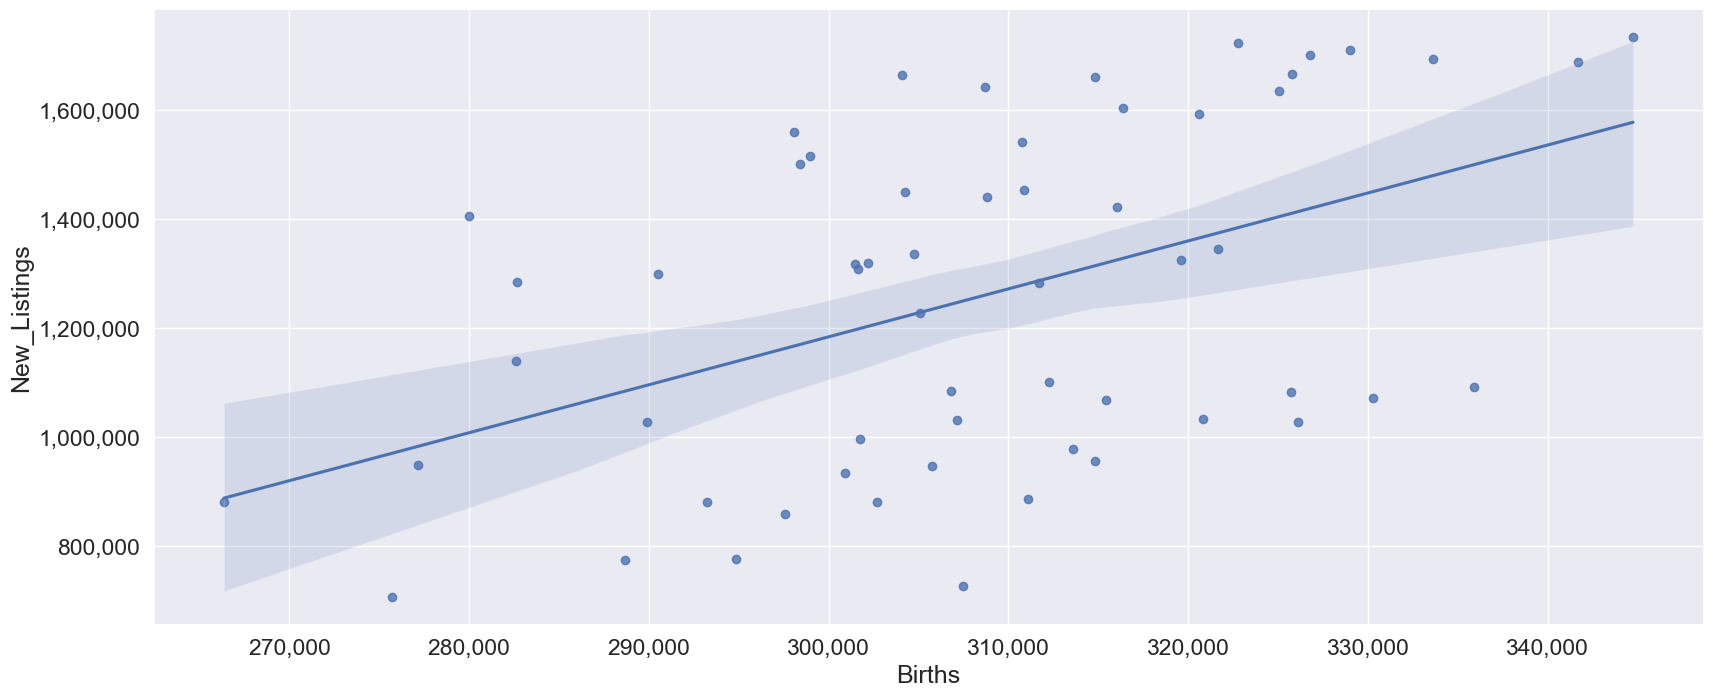

In [384]:
ax = sns.regplot(data = housing_data_df, x="Births", y="New_Listings", n_boot = 100)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('\
{x:,.0f}'))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('\
{x:,.0f}'))

Our graph is quite scattered, so this is an indication that our model is not the best fit. However, of the models we could make, a linear regression fit the best.

### Research Sub-question 2:

In the second research question we want to examine if the duration a house remains on the market before entering a pending status affects the ratio of the initial sale price of the house and the final sale price. This information is crucial for sellers to know when the most optimal time to accept an offer is to maximize their profit. We predict that there will be a negative relationship between the log-days until pending and the sale-to-list price ratio. This is because the longer a house stays on the market, the sellers will be more likely to decrease the price of the house in hopes of increasing offers. 

&emsp;$H_0: β_{days\_to\_pending} >= 0$ <br>
&emsp;$H_A: β_{days\_to\_pending} < 0$

At the 5% significance level where alpha = 0.05, we will reject the null hypothesis, that the number of log-days until pending has no or a positive impact on the ratio of the initial sale price and final price, if our p-value is less than 0.05.


We will first look at the relationship between how long a house remains for sale and the sale-to-list price ratio. 

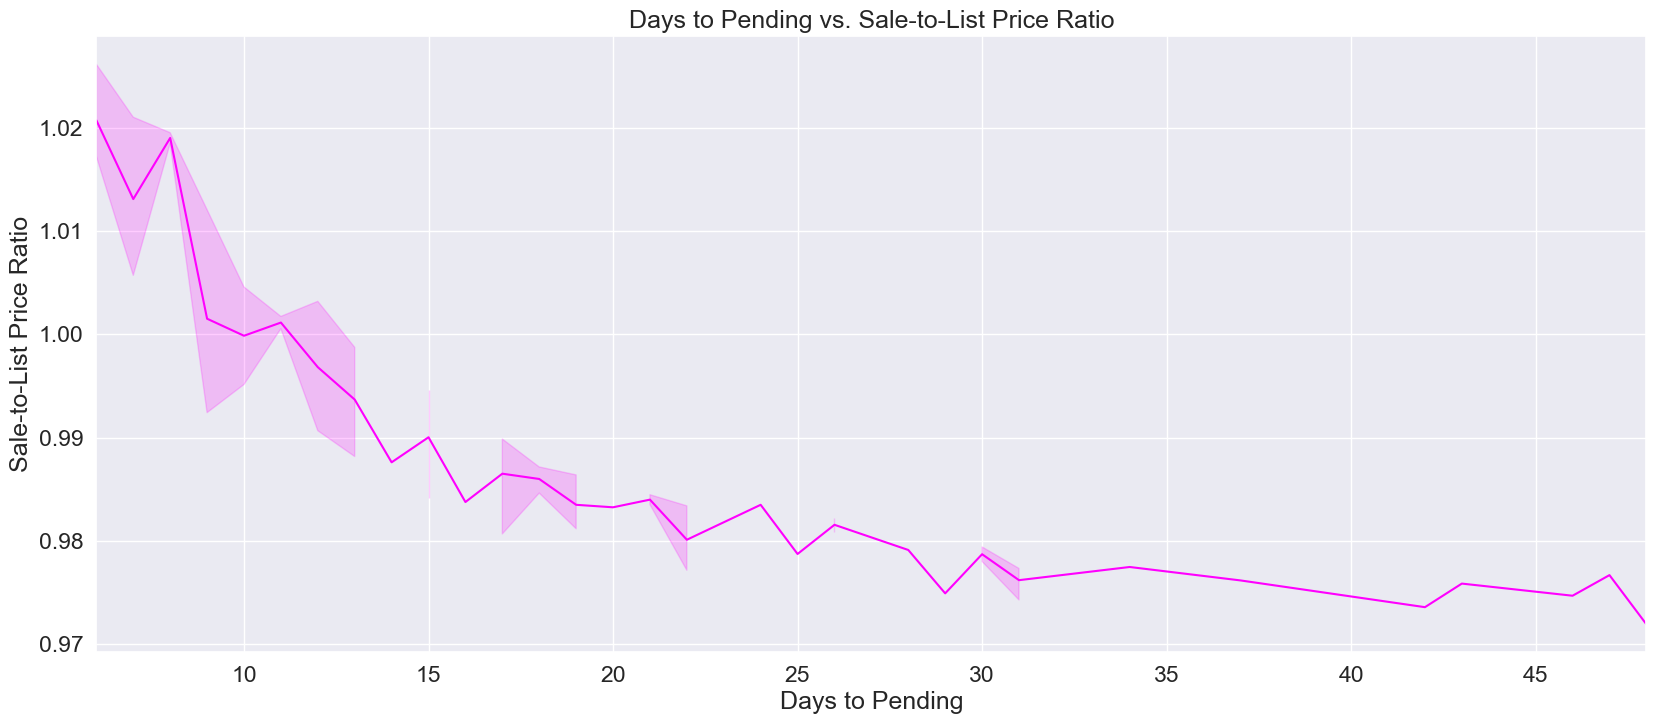

In [385]:
sns.lineplot(data=housing_data_df, x='Days_To_Pending', \
             y='Sale_To_List_Price_Ratio', color='magenta')
plt.title("Days to Pending vs. Sale-to-List Price Ratio")
plt.xlabel("Days to Pending")
plt.ylabel("Sale-to-List Price Ratio")
plt.margins(x=0);

The line graph indicates a negative relationship between days to pending and sale-to-list price ratio. As the number of days it takes from a house’s status to change from listed to pending increases, the ratio of homes sold above their final listing price decreases.

One big limitation of our data is the fact that our dataset is so small. However, for this analysis, we have more data that is readily available. We will look at the data on a weekly basis. This increases our dataset from 69 rows to 300 rows, which means that we can create a more accurate model and conduct more meaningful analysis. It also allows us to look at more detailed changes, since the time interval between rows is smaller.

Here we imported the weekly Zillow data.

In [386]:
df_zillow_weeks = pd.read_csv("df_zillow_weeks.csv")
reg_df_2 = df_zillow_weeks[["Days_To_Pending", "Sale_To_List_Price_Ratio"]].dropna()

Again, we want to first validate that a linear regression model is the most appropriate model for our data. We use our functions to create the windows and predictions for our data on days to pending and sale-to-list price ratio.

In [387]:
windows = sliding_window(reg_df_2, 4)
preds = window_pred(windows, ["Days_To_Pending"], "Sale_To_List_Price_Ratio")

In [388]:
reg_df_2["Predictions"] = preds
reg_df_p_2 = reg_df_2.dropna().reset_index(drop=True)
residuals = reg_df_p_2["Sale_To_List_Price_Ratio"] - reg_df_p_2["Predictions"]

Now we will plot the actual sale-to-list price ratio against our predictions. 

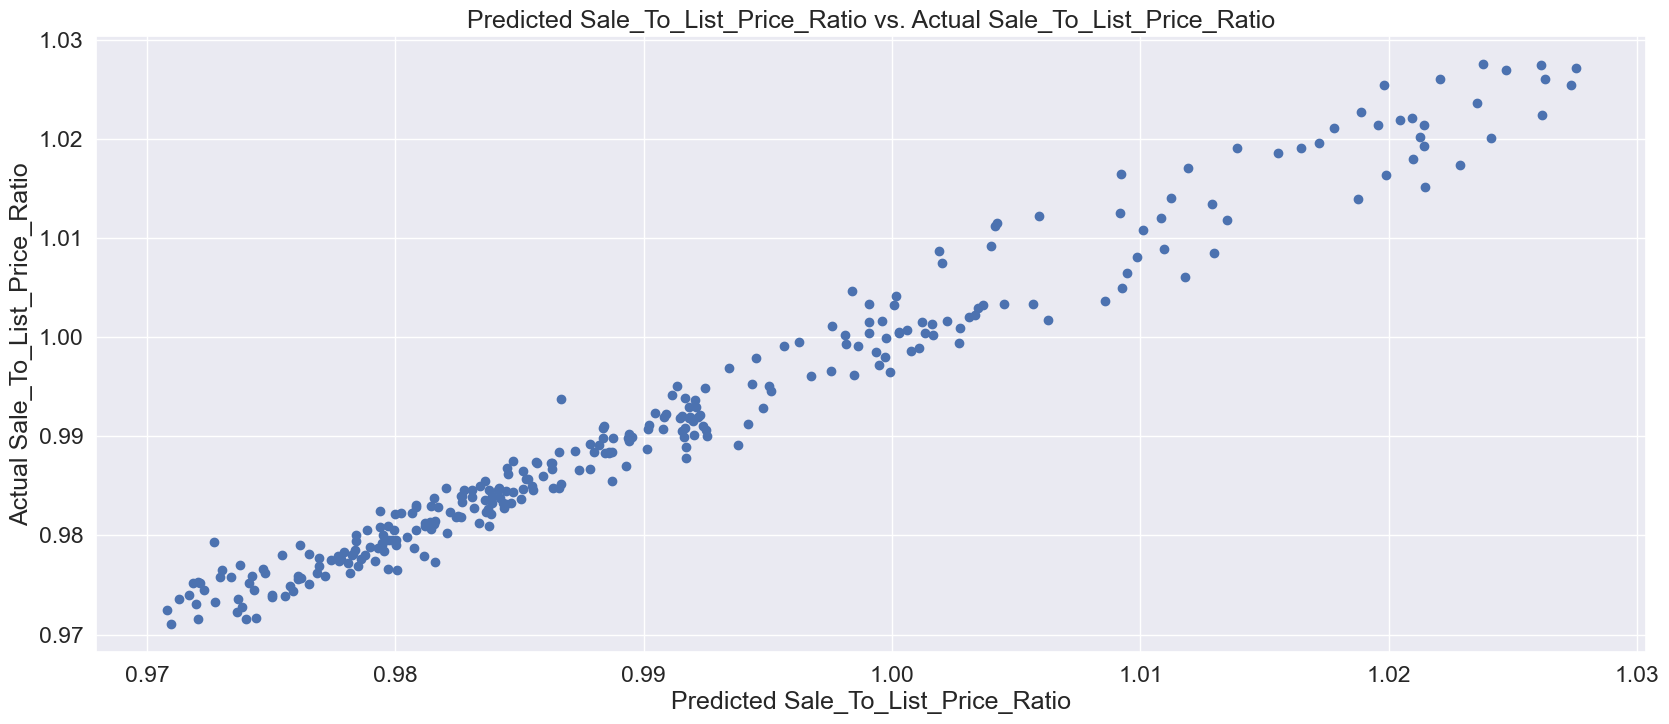

In [389]:
plt.scatter(x=reg_df_p_2["Predictions"], y=reg_df_p_2["Sale_To_List_Price_Ratio"])
plt.ylabel("Actual Sale_To_List_Price_Ratio")
plt.xlabel("Predicted Sale_To_List_Price_Ratio")
plt.title("Predicted Sale_To_List_Price_Ratio vs. Actual Sale_To_List_Price_Ratio");

We will also create the residual plot.

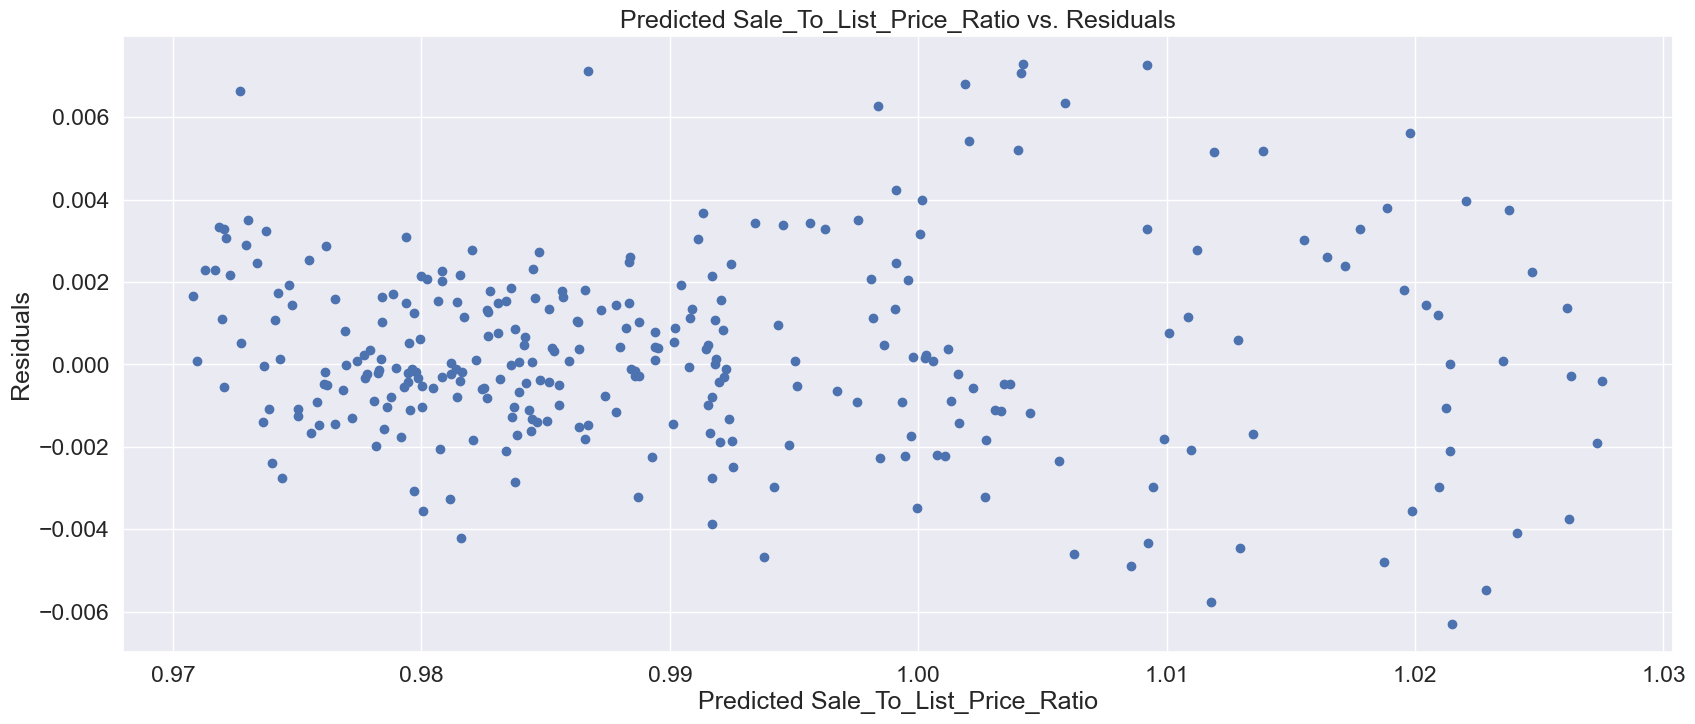

In [390]:
plt.scatter(x=reg_df_p_2["Predictions"], y=residuals)
plt.ylabel("Residuals")
plt.xlabel("Predicted Sale_To_List_Price_Ratio")
plt.title("Predicted Sale_To_List_Price_Ratio vs. Residuals")
plt.ylim();

We see that there is sort of a fan-shape that is going on in the graph. The residuals are closer together at the smaller end of the predicted sale-to-list-price ratio range, and have more variation when the ratio increases. This indicates heteroskedasticity within our data.

We will calculate the errors and build an OLS model with our current data. This will just give us a base starting point to compare the model created by our transformed data.

In [391]:
RMSE = mean_squared_error(reg_df_p_2["Sale_To_List_Price_Ratio"], 
                          reg_df_p_2["Predictions"], squared=False).round(6)
print(f"RMSE: {RMSE}")

MAE = mean_absolute_error(reg_df_p_2["Sale_To_List_Price_Ratio"], 
                          reg_df_p_2["Predictions"]).round(6)
print(f"MAE: {MAE}")

RMSE: 0.002346
MAE: 0.001755


The errors are pretty small already, but we will compare the errors from our transformed data model. We will use the OLS model's results to get an R-squared value that we can also use to compare our models.

In [392]:
x = sm.add_constant(reg_df_2["Days_To_Pending"])
y = reg_df_2["Sale_To_List_Price_Ratio"]

model = sm.OLS(y,x)
results = model.fit()
print(results.summary())

                               OLS Regression Results                               
Dep. Variable:     Sale_To_List_Price_Ratio   R-squared:                       0.587
Model:                                  OLS   Adj. R-squared:                  0.585
Method:                       Least Squares   F-statistic:                     422.7
Date:                      Mon, 04 Dec 2023   Prob (F-statistic):           4.28e-59
Time:                              21:57:24   Log-Likelihood:                 983.95
No. Observations:                       300   AIC:                            -1964.
Df Residuals:                           298   BIC:                            -1957.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

Now, we will make a regression plot of our data. The line represents the line of best fit that is generated by our model.

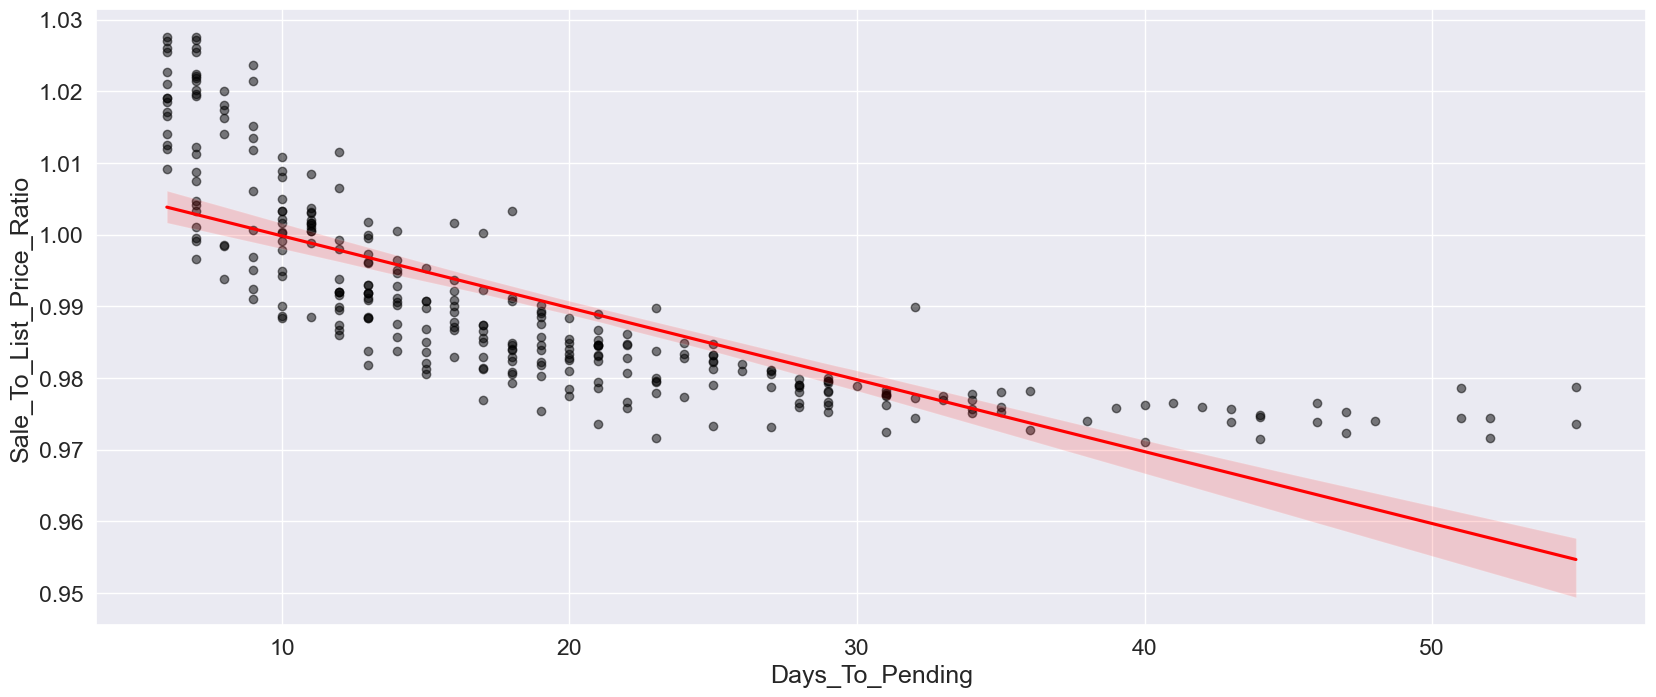

In [393]:
sns.regplot(data = df_zillow_weeks, x="Days_To_Pending", 
            y="Sale_To_List_Price_Ratio", n_boot = 100,
            scatter_kws={"color": "black", 'alpha':0.5}, line_kws={"color": "red"});

We notice that there is a downward trend in our residual plot, but a linear regression would not be a good fit. The general shape of the datapoint is curved, and it's especially noticeable at the higher `Days_To_Pending` values. So, we wanted to see if there was another model that could be a better fit. We decided to do a linear log transformation.  

Now that we know how we are going to transform the data, we will create a new column that takes the log of the days to pending column.

In [394]:
reg_df_2['Days_To_Pending_Log'] = np.log(reg_df_2['Days_To_Pending'])
housing_data_df['Days_To_Pending_Log'] = housing_data_df['Days_To_Pending']

We'll take a look at the new regression plot.

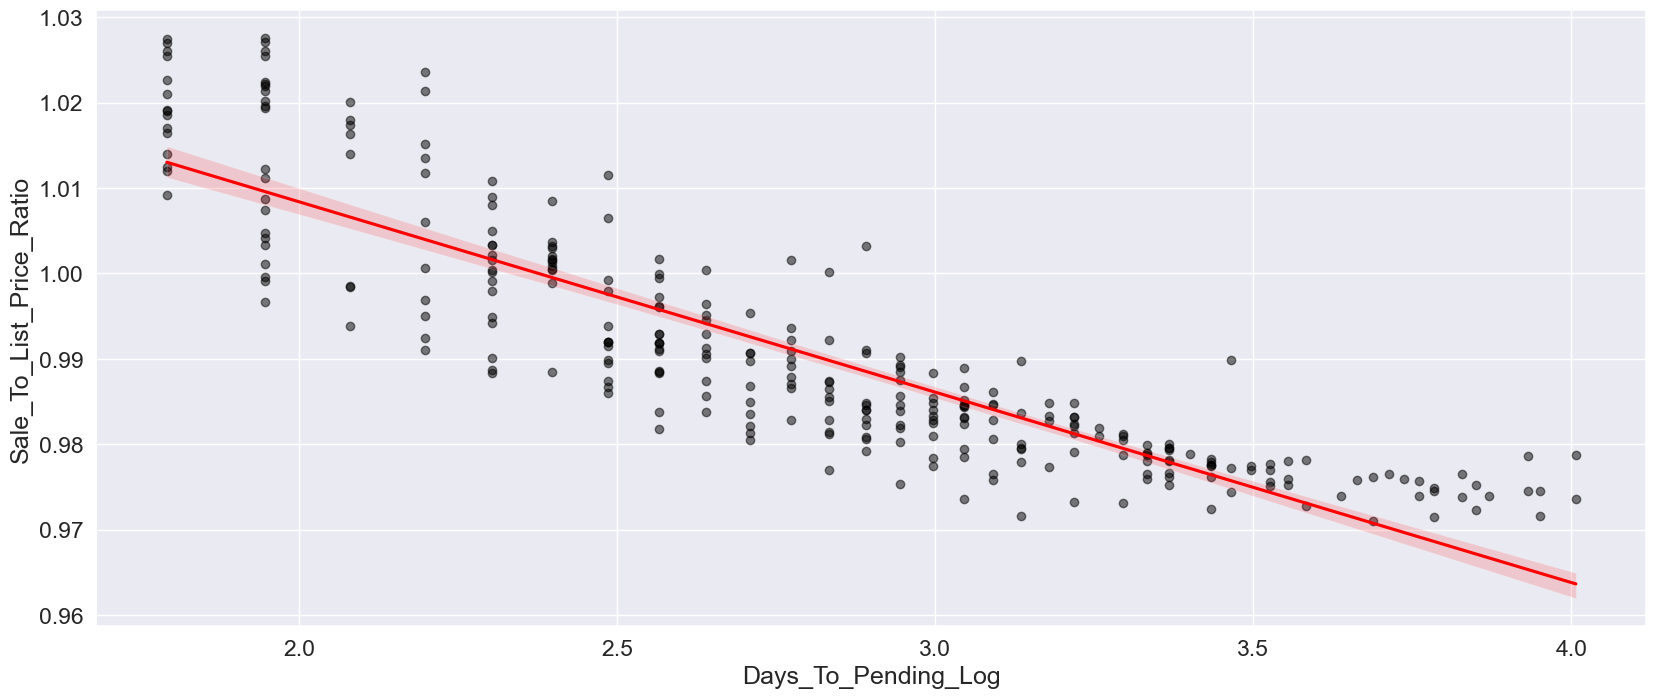

In [395]:
sns.regplot(x=reg_df_2["Days_To_Pending_Log"], y=reg_df_2["Sale_To_List_Price_Ratio"], \
            scatter_kws={"color": "black", 'alpha':0.5}, line_kws={"color": "red"}, \
            n_boot = 100);

This model seems more appropriate. It reduces the distance between our regression line and the data points, and the shape of the points is more linear as well.

Now we create the windows and predictions for our data on days to pending and sale-to-list price ratio.

In [396]:
windows = sliding_window(reg_df_2, 4)
preds = window_pred(windows, ["Days_To_Pending_Log"], "Sale_To_List_Price_Ratio")

In [397]:
reg_df_2["Predictions_Log"] = preds
reg_df_p_2 = reg_df_2.dropna().reset_index(drop=True)
residuals_log = reg_df_p_2["Sale_To_List_Price_Ratio"] - reg_df_p_2["Predictions_Log"]

Then, we'll plot the predictions to the actual values. We are doing this to check if the performance of this model is better than the model from before we transformed the data.

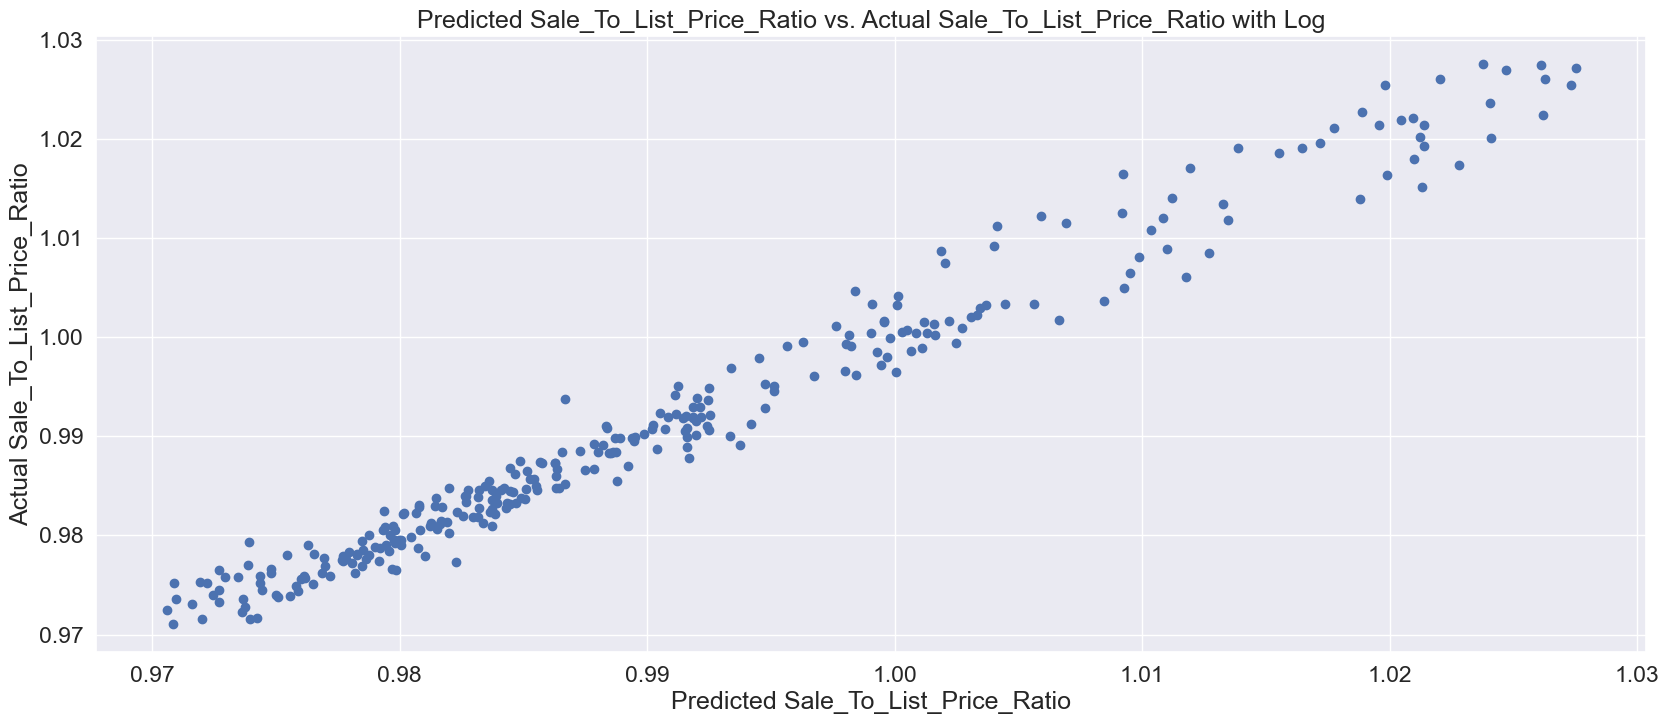

In [398]:
plt.scatter(x=reg_df_p_2["Predictions_Log"], y=reg_df_p_2["Sale_To_List_Price_Ratio"])
plt.ylabel("Actual Sale_To_List_Price_Ratio")
plt.xlabel("Predicted Sale_To_List_Price_Ratio")
plt.title("Predicted Sale_To_List_Price_Ratio vs. \
Actual Sale_To_List_Price_Ratio with Log");

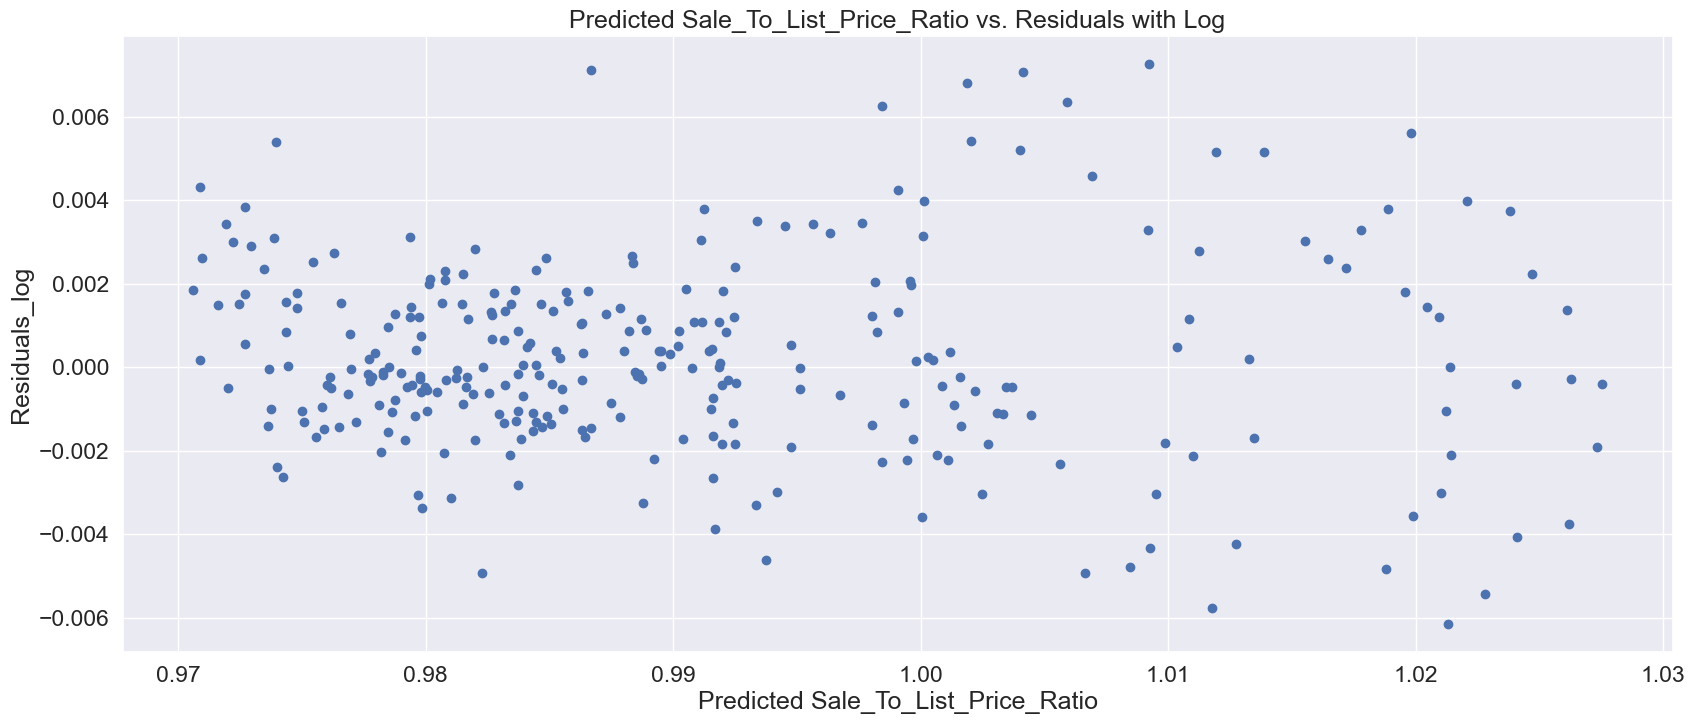

In [399]:
plt.scatter(x=reg_df_p_2["Predictions_Log"], y=residuals_log)
plt.ylabel("Residuals_log")
plt.xlabel("Predicted Sale_To_List_Price_Ratio")
plt.title("Predicted Sale_To_List_Price_Ratio vs. Residuals with Log");

The residuals here are more spread out than in the previous graph. There is still a slight resemblance of the fan shape, so it's possible that a different transformation method could be better. Determing this would require more testing and evaluation of models.

We will take a look at the errors as well.

In [400]:
RMSE = mean_squared_error(reg_df_p_2["Sale_To_List_Price_Ratio"], 
                          reg_df_p_2["Predictions_Log"], squared=False).round(6)
print(f"RMSE: {RMSE}")

MAE = mean_absolute_error(reg_df_p_2["Sale_To_List_Price_Ratio"], 
                          reg_df_p_2["Predictions_Log"]).round(6)
print(f"MAE: {MAE}")

RMSE: 0.002316
MAE: 0.001743


The RMSE and MAE are lower than they were before we took the log of our input variable. Since the transformation reduced our error, this further means that our model has improved.

So, now we will run the full OLS regression to get our statistics.

In [401]:
x = sm.add_constant(reg_df_2["Days_To_Pending_Log"])
y = reg_df_2["Sale_To_List_Price_Ratio"]

model = sm.OLS(y,x)
results = model.fit()
print(results.summary())

                               OLS Regression Results                               
Dep. Variable:     Sale_To_List_Price_Ratio   R-squared:                       0.772
Model:                                  OLS   Adj. R-squared:                  0.771
Method:                       Least Squares   F-statistic:                     1006.
Date:                      Mon, 04 Dec 2023   Prob (F-statistic):           1.53e-97
Time:                              21:57:24   Log-Likelihood:                 1072.9
No. Observations:                       300   AIC:                            -2142.
Df Residuals:                           298   BIC:                            -2134.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

Our model shows a coefficient of -0.0223. For a 1% increase in days until pending, we expect to see a corresponding decrease of .01*-0.0223 = -0.000223 in the sale-to-list price ratio. Since our p-value is 0.000, we can reject the null hypothesis at the 5% significance level and conclude that there is a negative relationship between days until pending and the sale-to-list price ratio. 

## General Research Question: Can we Predict the Number of New Listings or Sale-to-List-Price Ratio Based on our Input Factors?

Now that we have done some preliminary exploration between our variables, we want to answer our initial question–how do social and economic factors affect metrics of the housing market?

As mentioned initially, we will be characterizing the housing market by looking at the number of new listings per month, and the sale-to-list-price ratio. We will be running multilinear regressions to look at the role that multiple factors play. 

### Selecting Variables for Multi Linear Regression models

The first thing we needed to consider for our regressions is feature selection—the variables that we will use as our inputs. For each of our target variables, we narrowed down what features to include using domain expertise.

To start off with the number of new listings, we are going to use `Births`, `Deaths`, `Inflation_Rate`, `Unemployment_Rate`, and `Months_Since_Jan_2018` as our inputs. We'll consider births because new additions to a family create incentive for a family to move. This may also affect people around them (such as extended family members, who might also be incentivized to move). We are including the death count, since homes may be inherited or resold. Inflation rate and unemployment rate are measures of the economy, and people may choose to list or not list their house based on how the economy is doing. We will also look at the months since January 2018 to see what effect time has on the number of new listings.

For `Sale_To_List_Price_Ratio`, we again used our domain expertise to determine which factors we will use to build our model. Ultimately, we chose `Days_To_Pending_Log`, `Inflation_Rate`, `Unemployment_Rate`, as well as `Months_Since_Jan_2018` as our input variables. We will consider the number of days to pending because more time on the market may change a seller’s flexibility in the sale price. We are using the log-transformed `Days_To_Pending` because that is what we determined in our analysis for sub-question 2. We will include inflation and unemployment rates because those reflect changes in the economy, and will also change sellers’ expectations. Lastly, we include the months since January 2018 to see the effect of time.

Once we have which variables we are going to include in each regression, we create a residual plot to ensure that a linear relationship is appropriate for each variable.

In [402]:
def create_residuals(x, y):
    model = LinearRegression().fit(x, y)
    predictions = model.predict(x)
    residuals = y -  predictions
    return residuals, predictions

Births


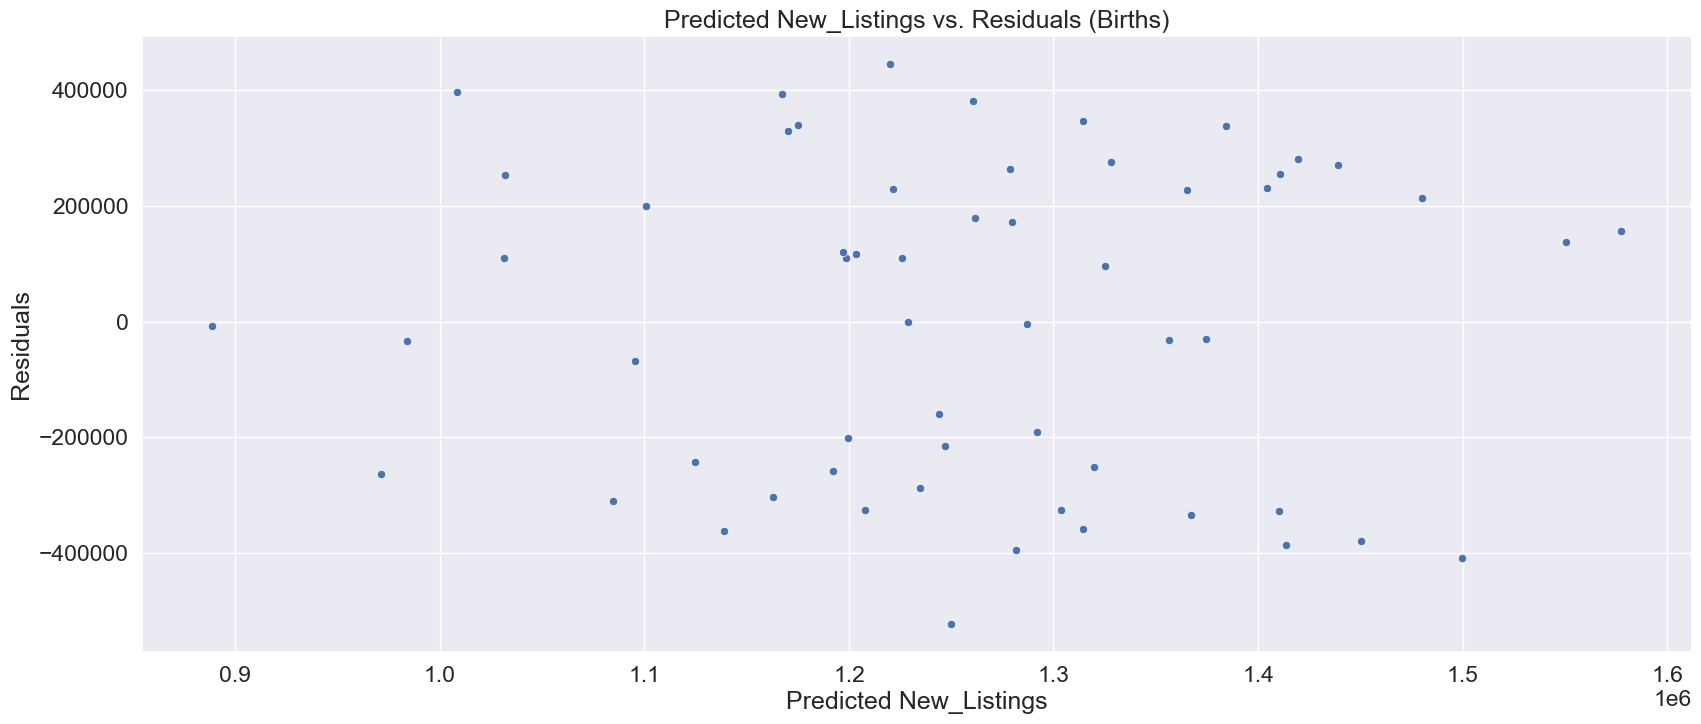

Deaths


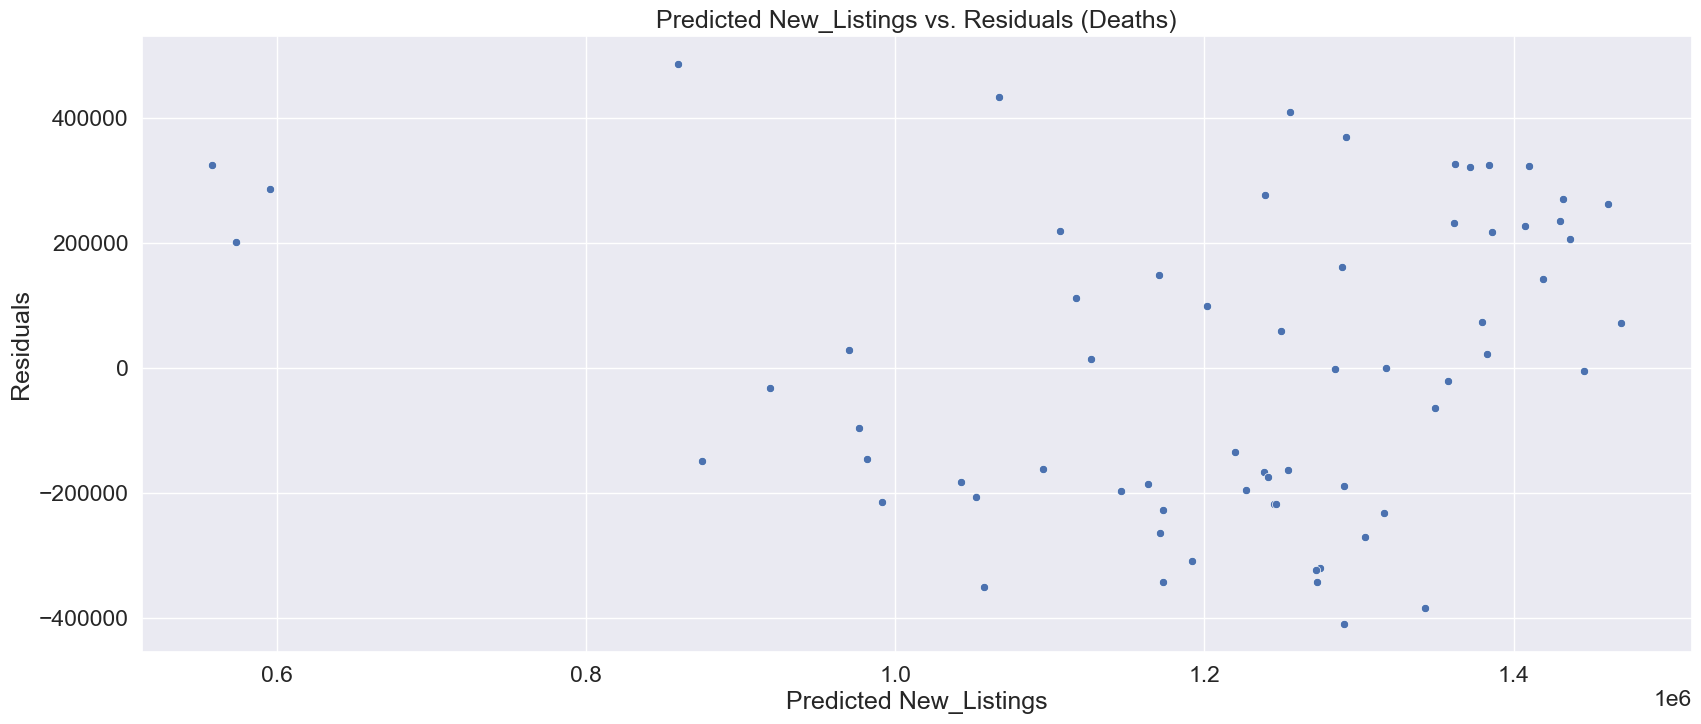

Inflation_Rate


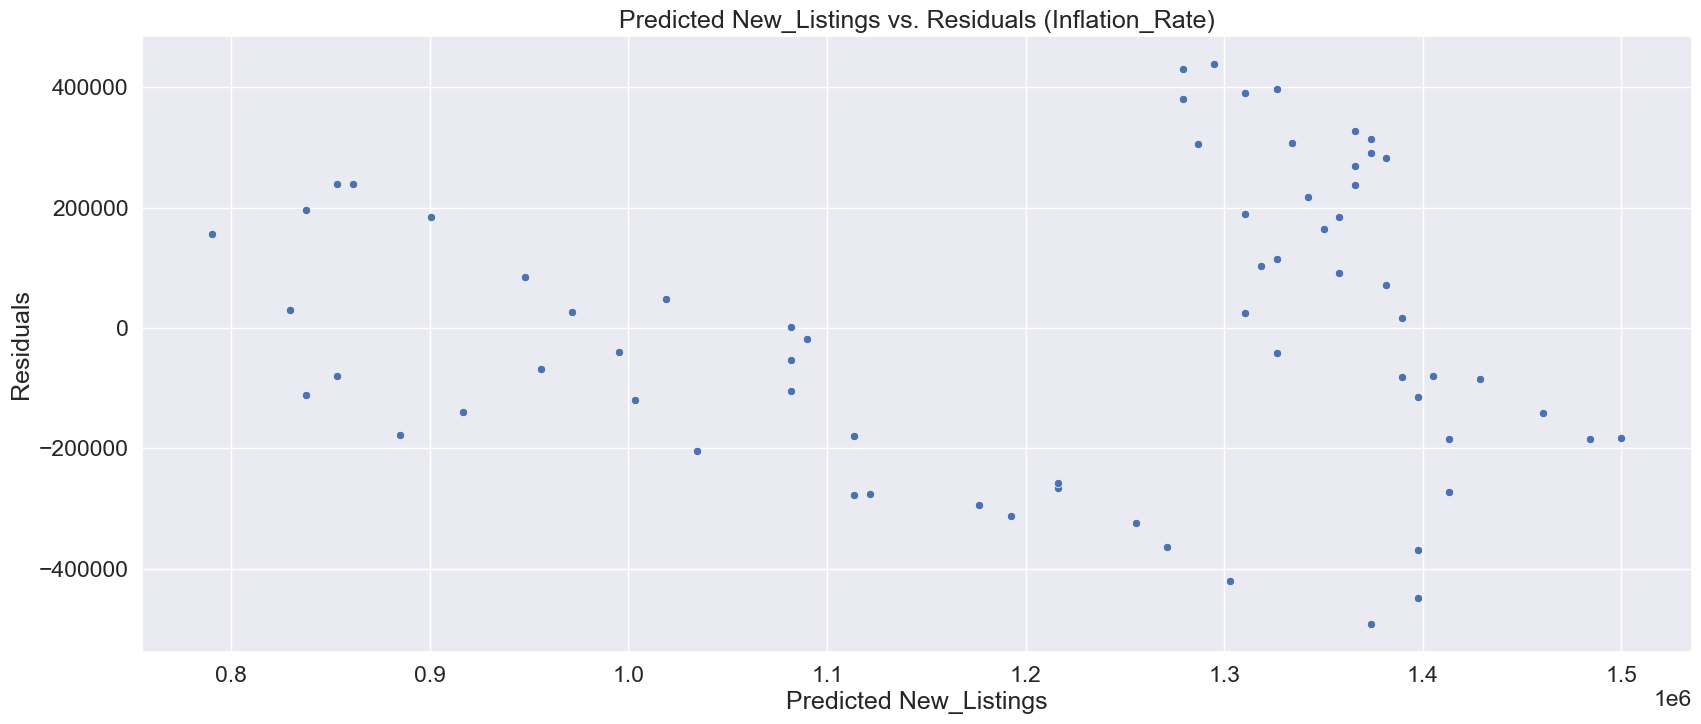

Unemployment_Rate


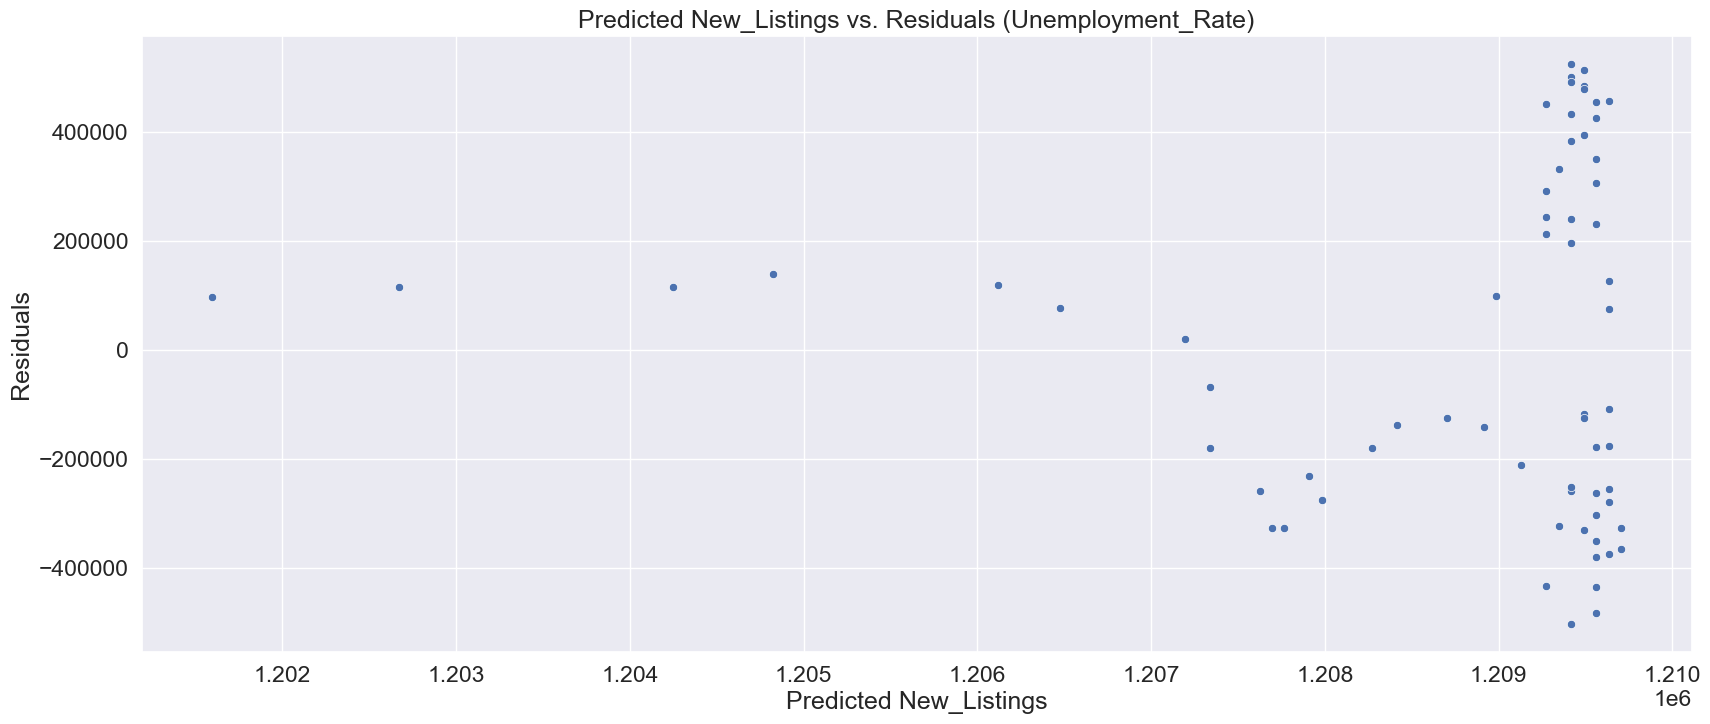

Months_Since_Jan_2018


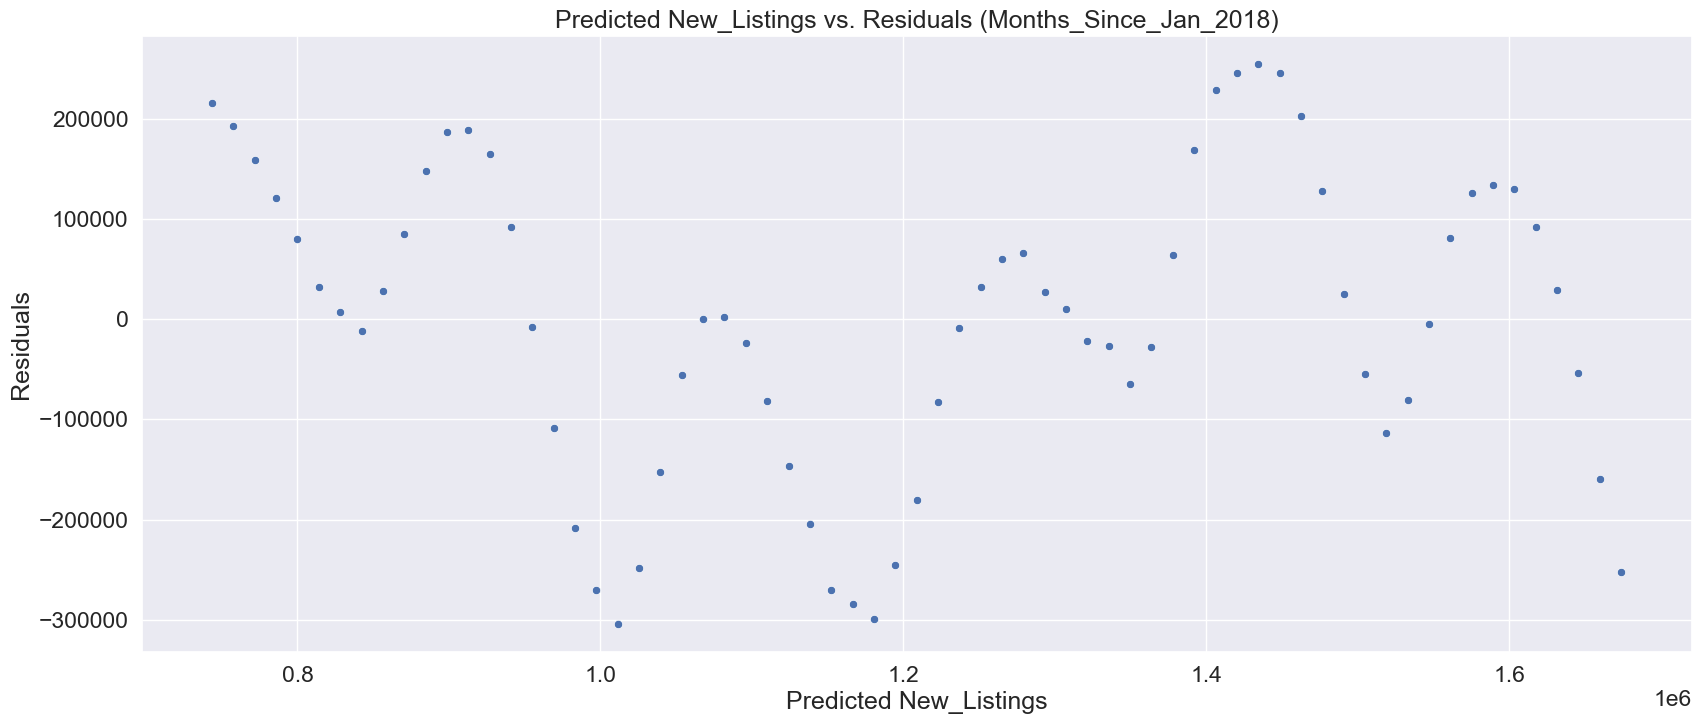

In [403]:
var = housing_data_df[["Births", "Deaths", "Inflation_Rate", "Unemployment_Rate", \
                       "Months_Since_Jan_2018"]].columns
for v in var:

    print(v)
    resid_df = housing_data_df[[v, "New_Listings"]].dropna().reset_index(drop=True)

    residuals, predictions = create_residuals(resid_df[[v]], resid_df['New_Listings'])
    sns.scatterplot(data=resid_df, x=predictions, y=residuals)
    plt.ylabel("Residuals")
    plt.xlabel("Predicted New_Listings")
    plt.title(f"Predicted New_Listings vs. Residuals ({v})");
    plt.show()

The residuals for `Births` and `Deaths` look randomly scattered, which indicates that a linear relationship between those variables and `New_Listings` is fine.

We see an interesting pattern sort of appear for `Inflation_Rate`. However, it is hard to determine what transformation (if any) should be done to the data in order to be able to use a linear model. Based on our further observation of visualizations of the data, we will proceed with using the data as is in our linear regression model. However, we must keep in mind that there may be a better way to utilize this data. The same goes for `Unemployment_Rate`. One big issue is that our dataset is really small. If we had more datapoints, we would likely be able to get a clearer picture from these residuals. 

The residuals for `Months_Since_Jan_2018` also have a clear pattern going on. Since the original data was cyclical, using a linear model also caused the regressions to look cyclical. It is likely that a trigonometric transformation would help, however our original data was rather irregularly cyclical, and this would cause a complex transformation. Because we noticed a general decline in the number of new listings over time, and due to time and ability constraints, we are also going to leave the data as-is. Again, it is important to keep in mind that a better model likely exists.

Now we are going to create the residual plots for our input variables for `Sale_To_List_Price_Ratio`.

Inflation_Rate


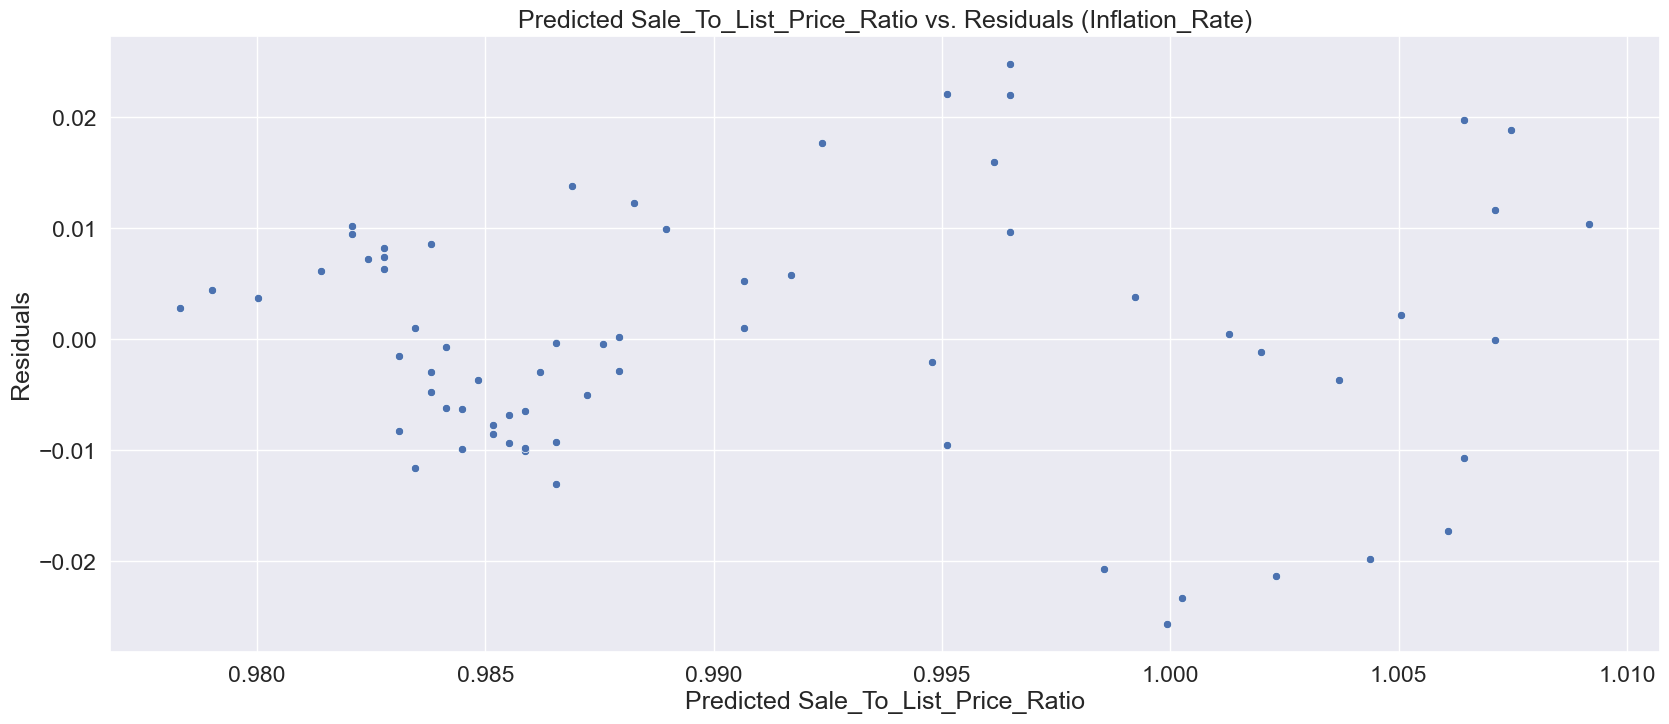

Unemployment_Rate


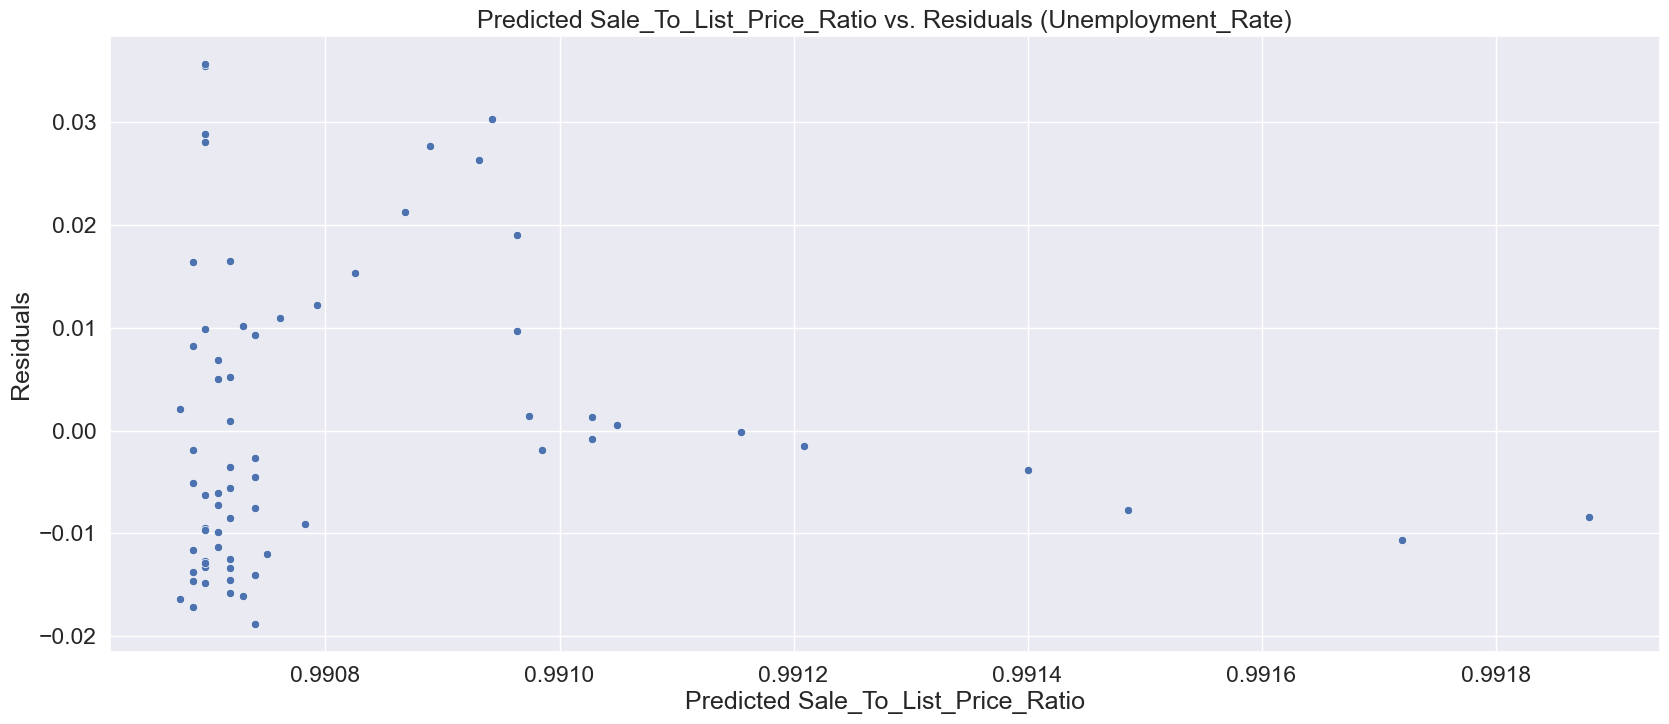

Months_Since_Jan_2018


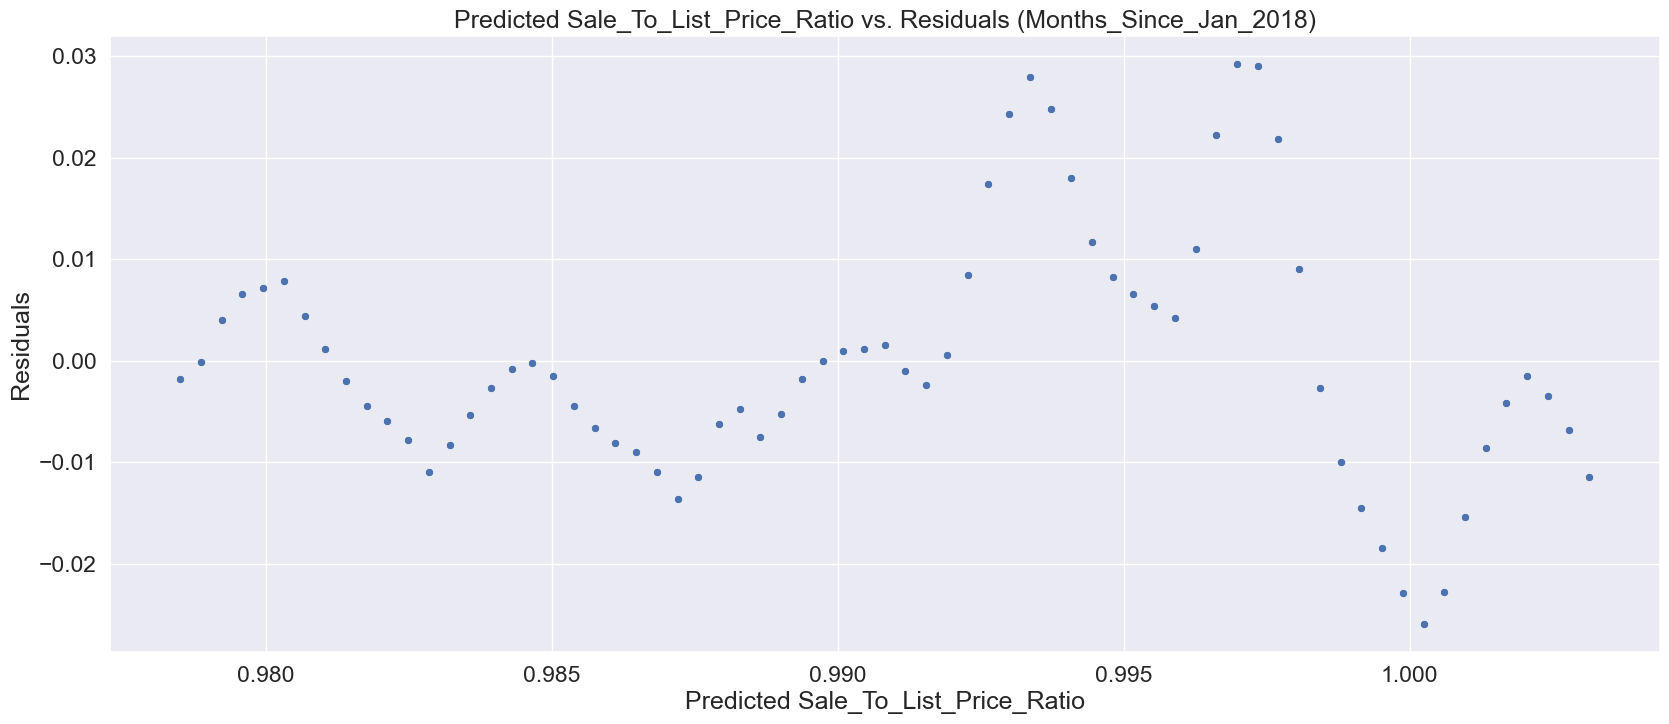

In [404]:
var = housing_data_df[["Inflation_Rate", "Unemployment_Rate", \
                       "Months_Since_Jan_2018"]].columns
for v in var:

    print(v)
    resid_df = \
    housing_data_df[[v, \
                     "Sale_To_List_Price_Ratio"]].dropna().reset_index(drop=True)
    
    residuals, predictions = create_residuals(resid_df[[v]], \
                                              resid_df['Sale_To_List_Price_Ratio'])
    sns.scatterplot(data=resid_df, x=predictions, y=residuals)
    plt.ylabel("Residuals")
    plt.xlabel("Predicted Sale_To_List_Price_Ratio")
    plt.title(f"Predicted Sale_To_List_Price_Ratio vs. Residuals ({v})")
    plt.show()

The residual plot for `Inflation_Rate` looks randomly scattered. However, we sort of see a shape appear for `Unemployment_Rate` again. The big issue for this is the fact that we don't have a lot of data points, and especially for unemployment rate, most of our data is clustered around lower unemployment rates. If we had more data to cover the whole range of possible unemployment rates, that would considerably improve our ability to analyze the data. We we unable to find a suitable transformation, so we will leave the data as-is.

Also, the residuals for `Months_Since_Jan_2018` show a sort of cyclical pattern again. The same explanation from above applies; so we will leave the data as-is.

### Multiple Linear Regression for `New_Listings`

Can we predict the number of new listings based on the factors that we have defined? Our hypotheses are as follows:

&emsp;$H_0:$ There is no relationship between our input variables and the number of new listings per month <br>
&emsp;$H_A:$ There is a relationship between our input variables and the number of new listings per month 

Again, we will be using a 5% significance level.

We will start our by isolating the variables we are going to use for this model. This is for the purpose of cutting out rows with missing values, while not affecting our main dataframe. 

Then, we will create an OLS regression and print out the results.

In [405]:
multi_reg_df_1 = housing_data_df[["New_Listings", "Deaths", "Births", \
                                  "Inflation_Rate", "Unemployment_Rate", \
                                  "Months_Since_Jan_2018"]]
multi_reg_df_1 = multi_reg_df_1.dropna().reset_index(drop=True)

x = sm.add_constant(multi_reg_df_1[["Deaths", "Births", "Inflation_Rate", \
                                    "Unemployment_Rate", \
                                    "Months_Since_Jan_2018"]])
y = multi_reg_df_1["New_Listings"]

model = sm.OLS(y,x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           New_Listings   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     116.8
Date:                Mon, 04 Dec 2023   Prob (F-statistic):           1.08e-26
Time:                        21:57:25   Log-Likelihood:                -729.32
No. Observations:                  57   AIC:                             1471.
Df Residuals:                      51   BIC:                             1483.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  7.136e+

From our results, the p-values for `Deaths`, `Births`, `Inflation_Rate`, and `Months_Since_Jan_2018` are less than 0.05. At the 5% significance level, we can say that we reject the null hypothesis and these variables do have an effect on the number of new listings. `Unemployment_Rate` has a p-value of 0.332, which is greater than 0.05, so it is not significant.

The coefficient for `Deaths` is -2.0472. That means, holding all else equal, for each additional death, we should expect the number of new listings to decrease by 2.0472. The coefficient for `Births` is 4.9468. That means, according to our model, holding all else equal, for each additional birth in a month, we should expect 4.9468 more listings. It should be noted that these coefficients don't show the whole picture; there are houses listed on the market for reasons other than a new family member or a loss in the family. More analysis would have to be done on specifically these two variables to better understand whether or not a birth or a death would specifically cause an *individual* to list their house. We are just looking at general changes to the market as a whole.

The coefficient for `Inflation_Rate` is -2.11e+04. That means, holding all else equal, that if the inflation rate increases by an addition 1 percent (percent as a unit, not a 1% change), we should expect the number of new listings in a month to decrease by about 2,110.

The coefficient for `Months_Since_Jan_2018` is -1.064e+04. For each additional month since January 2018,h olding all else equal, we should expect about 1,064 less houses being newly listed that month. 

We also see that there is a constant of about 73,160. It has a p-value of 0.028, so it is significant. That means that in January 2018, if the birth count is 0, the death count is 0, and the inflation rate and unemployment rate are both 0%, then we should expect to see 73,160 houses being listed on the market.

Thus, our relationship is modeled by this equation: <br>
&emsp; $\hat{y}=73160 - 2.0472x_{Deaths} + 4.9468x_{Births} - 2110x_{Inflation\_Rate} - 1064x_{Months\_Since\_Jan\_2018}$ <br>
Where $\hat{y}$ represents the predicted number of new listings.

The OLS regression also notes that there might be strong multicollinearity between our variables. This means that our model is not necessarily accurate, and our significance factors may not be correct.

We will also use our model to calculate the RMSE and MAE. This will give us an idea of how accurate our model is. 

In [406]:
RMSE = mean_squared_error(multi_reg_df_1["New_Listings"], 
                          results.predict(x), squared=False).round(2)
print(f"RMSE: {RMSE}")

MAE = mean_absolute_error(multi_reg_df_1["New_Listings"], 
                          results.predict(x)).round(2)
print(f"MAE: {MAE}")

RMSE: 87214.3
MAE: 70623.98


The errors here seem quite large, although our `New_Listings` column is in the millions, so relative to the quantity of new listings, the errors are not extreme. Our model performs okay, but due to this calculation and what we found before, there is probably a better model that could have been built.

We will also verify our new model using the sliding window validation as we did before. So, we calculate the windows and predictions, then graph the residuals.

In [407]:
windows = sliding_window(multi_reg_df_1, 3)
preds = window_pred(windows, ["Births", "Inflation_Rate", "Unemployment_Rate", \
                              "Months_Since_Jan_2018"], "New_Listings")
preds_vs_actual = pd.DataFrame({'New_Listings': multi_reg_df_1["New_Listings"], \
                                'Predictions': preds}).dropna()

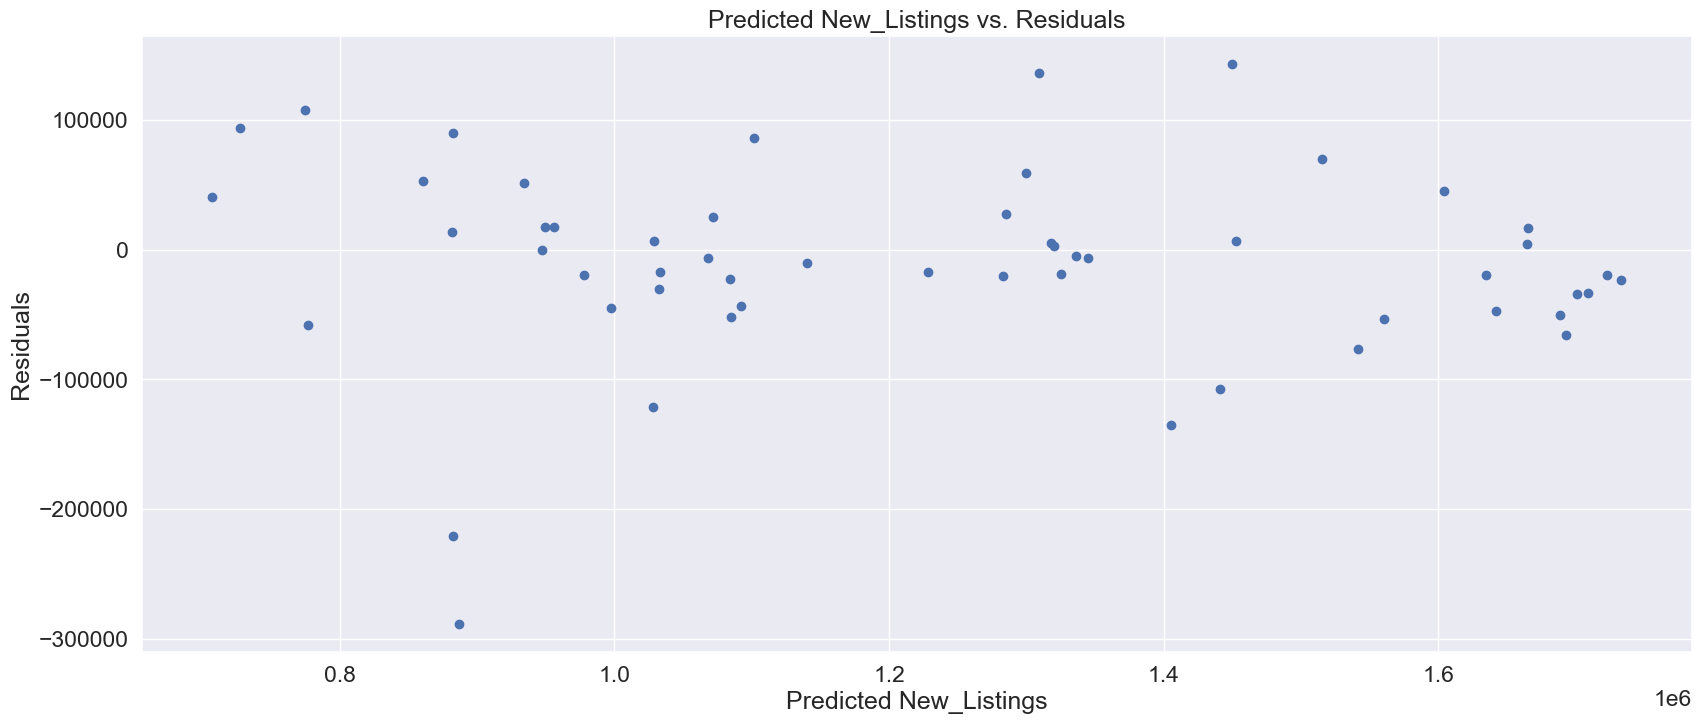

In [408]:
residuals = preds_vs_actual["New_Listings"] - preds_vs_actual["Predictions"]

plt.scatter(x=preds_vs_actual["New_Listings"], y=residuals)
plt.ylabel("Residuals")
plt.xlabel("Predicted New_Listings")
plt.title("Predicted New_Listings vs. Residuals");

As shown in the residual plot, the residuals are randomly scattered across the graph. That means that there is no heteroskedasticity or other issues within the variance of our data.

In [409]:
RMSE = mean_squared_error(preds_vs_actual["New_Listings"], 
                          preds_vs_actual["Predictions"], squared=False).round(1)
print(f"RMSE: {RMSE}")

MAE = mean_absolute_error(preds_vs_actual["New_Listings"], 
                          preds_vs_actual["Predictions"]).round(1)
print(f"MAE: {MAE}")

RMSE: 75428.0
MAE: 51730.3


Interestingly, the errors with from the sliding window are smaller than the errors generated by our model on the whole dataset. It is possible that this is because the sliding window creates less points to be predicted. Regardless, the errors are still quite big. There is likely more exploration we could do to build a more accurate model.

#### Predictions and Oddities

Using our model that we made above, we have found that since the coefficients for `Births`, `Deaths`, `Inflation_Rate`, and `Months_Since_Jan_2018` are significant, we can make predictions for `New_Listings` using those values.

In January 2024 (72 months after January 2018), if there were 300000 new births in that month, 250000 deaths 3 months prior, and an inflation rate of 3.0%, we should expect 1,064,822 houses being newly listed that month.

There are certain conditions in which our model wouldn't hold. For instance, if it was January 2024, and all other input factors were 0, we would predict -3,448 new listings. This wouldn't make sense because by the way that we quantified `New_Listings`, we cannot have a negative number.

It should be noted that our input variables are also not quantities that can easily be predicted, and our calculated predictions are dependent on these variables. 

### Multiple Linear Regression for `Sale_To_List_Price_Ratio`

Can we predict the sale-to-list price ratio based on the factors that we have defined? Our hypotheses are as follows:

&emsp;$H_0:$ There is no relationship between our input variables and the mean sale-to-list-price ratio per month <br>
&emsp;$H_A:$ There is a relationship between our input variables and the mean sale-to-list-price ratio per month

We will be using a 5% significance level.

Again, we will start our by isolating the variables we are going to use for this model.

Then, we will create an OLS regression and print out the results.

In [410]:
multi_reg_df_2 = housing_data_df[["Sale_To_List_Price_Ratio", "Inflation_Rate", \
                                  "Unemployment_Rate", "Months_Since_Jan_2018"]]
multi_reg_df_2.insert(3, 'Days_To_Pending_Log', \
                      np.log(housing_data_df['Days_To_Pending']))

multi_reg_df_2 = multi_reg_df_2.dropna().reset_index(drop=True)

x = sm.add_constant(multi_reg_df_2[["Inflation_Rate", "Unemployment_Rate", \
                                    "Months_Since_Jan_2018", "Days_To_Pending_Log"]])
y = multi_reg_df_2["Sale_To_List_Price_Ratio"]

model = sm.OLS(y,x)
results = model.fit()
print(results.summary())

                               OLS Regression Results                               
Dep. Variable:     Sale_To_List_Price_Ratio   R-squared:                       0.863
Model:                                  OLS   Adj. R-squared:                  0.854
Method:                       Least Squares   F-statistic:                     100.8
Date:                      Mon, 04 Dec 2023   Prob (F-statistic):           6.80e-27
Time:                              21:57:26   Log-Likelihood:                 264.77
No. Observations:                        69   AIC:                            -519.5
Df Residuals:                            64   BIC:                            -508.4
Df Model:                                 4                                         
Covariance Type:                  nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

From the results, we see that `Inflation_Rate`, `Months_Since_Jan_2018`, and `Days_To_Pending_Log` have p-values that are less than 0.05. That means that they are statistically significant, so they have an impact on `Sale_To_List_Price_Ratio`. Unemployment rate has a p-value of 0.746, which is greater than 0.05. That means that it is not significant, so we cannot be sure if its coefficient measures the true effect. 

The coefficient of `Inflation_Rate` is 0.0018. According to our model, holding all else equal, if the inflation rate increases by 1 percent, we should expect the mean sale-to-list-price ratio to increase by 0.018.

The coefficient of `Months_Since_Jan_2018` is -0.0001. Holding all else equal, for each additional month since January 2018, the mean sale-to-list-price ratio should decrease by 0.0001, according to our model. 

The coefficient of `Days_To_Pending_Log` is -0.0216. According to our model, holding all else equal, if there is a 1 unit increase in the log of the number of days to pending, there should be a decrease of 0.0216 in the mean sale-to-list-price ratio. Alternatively, a 1% increase in the number of days to pending corresponds with a 0.000216 unit decrease in the mean sale-to-list-price ratio.

For this model, our equation for predicting the mean sale-to-list-price ratio in a given month is <br>
&emsp;$\hat{y}=1.0483 + 0.0018x_{Inflation\_Rate} - 0.0001x_{Months\_Since\_Jan\_2018} - 0.0216x_{Days\_To\_Pending\_Log}$ <br>
where $\hat{y}$ represents the predicted mean sale-to-list-price ratio.

We will also follow our same procedure from above of calculating the errors and residuals. 

In [411]:
RMSE = mean_squared_error(multi_reg_df_2["Sale_To_List_Price_Ratio"], 
                          results.predict(x), squared=False).round(6)
print(f"RMSE: {RMSE}")

MAE = mean_absolute_error(multi_reg_df_2["Sale_To_List_Price_Ratio"], 
                          results.predict(x)).round(6)
print(f"MAE: {MAE}")

RMSE: 0.005215
MAE: 0.004345


Considering that the sale-to-list-price ratio is a ratio that generally is around 1, our errors are pretty small. That means our model is doing a pretty good job of predicting using our current dataset.

Of course, will also use the sliding window validation on our data as well.

In [412]:
windows = sliding_window(multi_reg_df_2, 12)
preds = window_pred(windows, ['Inflation_Rate', "Unemployment_Rate", \
                              "Days_To_Pending_Log", "Months_Since_Jan_2018"], \
                    "Sale_To_List_Price_Ratio")
preds_vs_actual = pd.DataFrame({'Sale_To_List_Price_Ratio': \
                                multi_reg_df_2["Sale_To_List_Price_Ratio"], \
                                'Predictions': preds}).dropna()

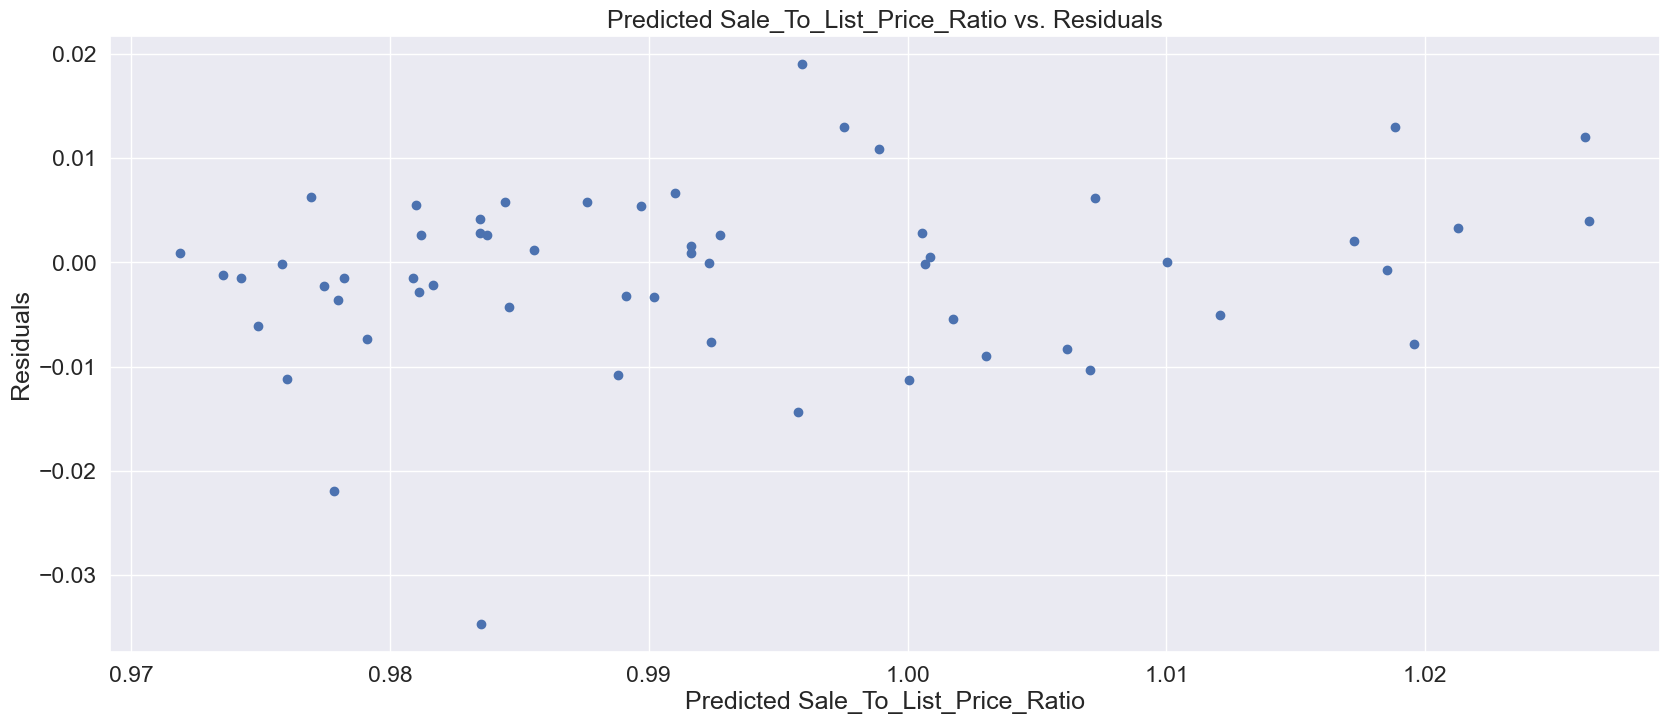

In [413]:
residuals = \
preds_vs_actual["Sale_To_List_Price_Ratio"] - preds_vs_actual["Predictions"]

plt.scatter(x=preds_vs_actual["Sale_To_List_Price_Ratio"], y=residuals)
plt.ylabel("Residuals")
plt.xlabel("Predicted Sale_To_List_Price_Ratio")
plt.title("Predicted Sale_To_List_Price_Ratio vs. Residuals");

Here, the residuals look pretty random, which is a good sign. That indicates no heteroskedasticity.

We'll also calculate the errors from the sliding window validation as well.

In [414]:
RMSE = mean_squared_error(preds_vs_actual["Sale_To_List_Price_Ratio"], 
                          preds_vs_actual["Predictions"], squared=False).round(6)
print(f"RMSE: {RMSE}")

MAE = mean_absolute_error(preds_vs_actual["Sale_To_List_Price_Ratio"], 
                          preds_vs_actual["Predictions"]).round(6)
print(f"MAE: {MAE}")

RMSE: 0.008551
MAE: 0.005992


These errors are a little greater than the errors from our OLS model on the whole dataset (calculated above), but they are not too far off. They are also sufficiently small.

#### Predictions and Oddities

Using our model that we made above, we have found that since the coefficients for `Inflation_Rate`, `Months_Since_Jan_2018`, and `Days_To_Pending_Log` are significant, we can make predictions for New_Listings using those values.

In January 2024, if the inflation rate was 3%, for a house that spent 14 days on the market before becoming “Pending”, we would expect its sale-to-list-price ratio to be 0.7441. That is, it should sell for only 74.41% of its original listing price.

Again, there are certain conditions that our model would not work for. For example, if we tried to predict a sale-to-list-price ratio value in January 2024, at a 3% inflation rate, for a house that spent 100 days before becoming “Pending”, we would calculate a ratio of −1.1135. It doesn’t make sense for our `Sale_To_List_Price_Ratio` to be negative, since both the listing price and sale price should both be positive.

# Conclusions:

Our project explored the condition of the housing market in the United States from the years 2018-2023, and what socioeconomic factors (birth and mortality rates, inflation, and unemployment) impact the market. 

When performing a multiple linear regression on the number of new listings we found that there was a relationship between the number of births, inflation rate, unemployment rate, and the number of months since January 2018 and the number of new lisitings. While we found that our model was not the best-performing, our coefficients did show statistical significance. 

When analyzing sale-to-list price ratio we found that there was a relationship between inflation rate, the number of months since January 2018, and the log of the number of days until pending. The multiple linear regression model that we built here also performed decently.

The sale-to-list price ratio multivariate regression has the potential to be very valuable for homeowners considering listing their house and determining what factors can allow one to maximize their profit. The new listing multivariate regression results allows one to quantify the health of the market and make an educated decision on when to list their house. 

# __Data Limitations:__

Our question and data set create limitations in our data science project. First, the housing data we collected only accounts for houses listed on Zillow. While Zillow is the most popular electronic real estate website, many housing transactions happen off the web, especially in more rural areas of the country (Ahrefs, 2023). This overrepresentation is why much of their data sets are only available in groupings by metropolises, as urban housing markets only represent part of the real estate market of an entire state. 

Secondly, due to the limited availability of certain data, we were working with a small dataset because we only had data for the months between January 2018 and September 2023. This affected the our analysis because we didn't have a lot of data points to train our models on. If we had more data from previous years, it is likely that our models would be more accurate.

Another limitation in the Zillow data relates to which data they collect. We have the median days between when the owner accepts an offer (`Days_To_Pending`), but this only refers to when the seller first decides to proceed with an offer. We don’t have the amount of time from when a house is first listed to when it is officially sold.

We encountered more limitations when gathering data to cross-reference with our Zillow records. In addition to the ones included, we wanted to incorporate more factors, such as divorce, nursing homes, and marriage rates; however, we struggled to find data sets that had intervals in months to match our Zillow Data, which records the months between 2018 and August of 2023. We did not believe we could create accurate assessments with data sets that only had five data points. Furthermore, some of the data sets we collected do not continue past 2022, omitting the months 2023. This limitation will make it challenging to analyze our 2023 Zillow data.

Lastly, there are some columns that are missing data. `New_Listings` doesn't have data for January or February 2018, and `Births` stops at December 2022. Also, `Days_To_Pending` is the only column of data that we have regarding housing that contains data for September 2023. This limitation will affect our analyses because we will be working with different size columns. Some columns will have less data that we can use to create regressions.
